## Environment Setup

In [1]:
# To verify if the notebook is connected to gpu
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Aug 25 11:31:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# To get requirements.txt from github repository
!wget https://raw.githubusercontent.com/21062872/fraud-detection-rag/main/code_files/requirements.txt

--2024-08-25 11:31:49--  https://raw.githubusercontent.com/21062872/fraud-detection-rag/main/code_files/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 124 [text/plain]
Saving to: ‘requirements.txt’

requirements.txt    100%[===================>]     124  --.-KB/s    in 0s      

2024-08-25 11:31:49 (2.56 MB/s) - ‘requirements.txt’ saved [124/124]



In [3]:
# Install all libraries from requirements.txt
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 6.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nv

## Data Ingestion

In [4]:
import pandas as pd
# Class to load external files
class DataLoader:
    def __init__(self, url):
        self.url = url
        self.dataframe = None

    def load_data(self):
        """Load data from the URL into a Pandas DataFrame."""
        self.dataframe = pd.read_csv(self.url)
        return self.dataframe

In [5]:
# load data from external file
dataset_url = 'https://raw.githubusercontent.com/21062872/fraud-detection-rag/main/data_files/dataset.csv'
data_loader = DataLoader(dataset_url)
df_raw = data_loader.load_data()

In [6]:
df_raw.head(5)

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


In [7]:
df_raw.dtypes

,0
step,int64
customer,object
age,object
gender,object
zipcodeOri,object
merchant,object
zipMerchant,object
category,object
amount,float64
fraud,int64


## Data Pre-processing

In [8]:
import numpy as np
class DataPreprocessor:
    @staticmethod
    def preprocess(dataframe):
        """Preprocess the DataFrame by stripping single quotes from string values."""
        return dataframe.map(lambda x: x.strip("'") if isinstance(x, str) else x)

    @staticmethod
    def rename_columns(dataframe):
        """Rename columns of the DataFrame according to specified mappings. This is done as raw dataset has additional characters beside values"""
        renamed_columns = {
            'step': 'timeStep',
            'customer': 'customerId',
            'age': 'customerAge',
            'gender': 'customerGender',
            'zipcodeOri': 'originZipCode',
            'merchant': 'merchantName',
            'zipMerchant': 'merchantZipCode',
            'category': 'merchantCategory',
            'amount': 'amount',
            'fraud': 'isFraud'
        }
        return dataframe.rename(columns=renamed_columns)

    @staticmethod
    def preprocess_gender(dataframe):
        """
        Preprocess the 'customerGender' column by standardizing values and handling unknowns.

        Parameters:
        dataframe (pd.DataFrame)

        Returns:
        pd.DataFrame: The DataFrame with the preprocessed 'customerGender' column.
        """
        dataframe['customerGender'] = dataframe['customerGender'].replace({'E': np.nan, 'U': np.nan})
        return dataframe

    @staticmethod
    def convert_to_category_codes(df, column_name):
        """
        Convert a categorical columns category codes.

        Returns:
        pd.DataFrame: The DataFrame with the categorical column converted to category codes.
        """
        df[column_name] = df[column_name].astype('category').cat.codes
        return df

    @staticmethod
    def filter_records_with_unidentified_data(df, column_name):
        """
        Filters out rows where 'customerAge' is 'U'.

        Returns:
        pd.DataFrame: A DataFrame with rows where 'customerAge' is not 'U'.
        """
        filtered_df = df[df[column_name] != 'U']

        return filtered_df

    @staticmethod
    def process_columns(df):
        """
        Remove the first letter from 'customerId' and 'merchantName' columns,
        convert these columns to integers, and drop 'originZipCode' and
        'merchantZipCode' columns if they exist.

        Parameters:
        df (pd.DataFrame)

        Returns:
        pd.DataFrame: The DataFrame with 'customerId' and 'merchantName' columns processed,
                      and 'originZipCode' and 'merchantZipCode' columns removed.
        """
        # Remove the first letter and convert to integer for 'customerId'
        df['customerId'] = df['customerId'].str[1:].astype(int)

        # Remove the first letter and convert to integer for 'merchantName'
        df['merchantName'] = df['merchantName'].str[1:].astype(int)

        # Drop 'originZipCode' and 'merchantZipCode' columns if they exist
        columns_to_remove = ['originZipCode', 'merchantZipCode']
        df = df.drop(columns=[col for col in columns_to_remove if col in df.columns])

        return df



In [9]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

class CatergoricalEncoder:
    @staticmethod
    def encode_gender(dataframe):
        """
        Encode the 'customerGender' column using label encoding.

        Parameters:
        dataframe (pd.DataFrame)

        Returns:
        pd.DataFrame: The DataFrame with the label encoded 'customerGender' column,
                      including original and encoded columns.
        """

        # Initialize the label encoder
        label_encoder = LabelEncoder()

        # Fit and transform the 'customerGender' column
        dataframe['encoded_gender'] = label_encoder.fit_transform(dataframe['customerGender'].astype(str))

        return dataframe

    @staticmethod
    def encode_merchant_category(dataframe):
        """
        Encode the 'merchantCategory' column using label encoding.

        Parameters:
        dataframe (pd.DataFrame)

        Returns:
        pd.DataFrame: The DataFrame with the label encoded 'merchantCategory' column,
                      including original and encoded columns.
        """
        # Initialize the label encoder
        label_encoder = LabelEncoder()

        # Fit and transform the 'merchantCategory' column
        dataframe['encoded_category'] = label_encoder.fit_transform(dataframe['merchantCategory'].astype(str))

        return dataframe


In [10]:
# Preprocessing the dataset
data_preprocessor = DataPreprocessor()
df_processed = data_preprocessor.preprocess(df_raw)
df_processed = data_preprocessor.rename_columns(df_processed)
df_processed = data_preprocessor.preprocess_gender(df_processed)
df_processed = data_preprocessor.filter_records_with_unidentified_data(df_processed, 'customerAge')
df_processed = data_preprocessor.process_columns(df_processed)

In [11]:
# Encode the 'customerGender' column
df_processed = CatergoricalEncoder.encode_gender(df_processed)

# Encode the 'merchantCategory' column
df_processed = CatergoricalEncoder.encode_merchant_category(df_processed)


In [12]:
df_processed.tail(5)

,timeStep,customerId,customerAge,customerGender,merchantName,merchantCategory,amount,isFraud,encoded_gender,encoded_category
594638,179,1753498738,3,F,1823072687,es_transportation,20.53,0,0,12
594639,179,650108285,4,F,1823072687,es_transportation,50.73,0,0,12
594640,179,123623130,2,F,349281107,es_fashion,22.44,0,0,2
594641,179,1499363341,5,M,1823072687,es_transportation,14.46,0,1,12
594642,179,616528518,4,F,1823072687,es_transportation,26.93,0,0,12


In [21]:
df_processed.dtypes

,0
timeStep,int64
customerId,int64
customerAge,object
customerGender,object
merchantName,int64
merchantCategory,object
amount,float64
isFraud,category
encoded_gender,int64
encoded_category,int64


### Exploratory Data Analysis (EDA)

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import missingno as msno

class EDA:
    def __init__(self, df):
        self.df = df

    def plot_imbalance(self, target_variable):
        """Plot the class imbalance for fraud variable."""
        # Setting the aesthetic style of the plots
        sns.set_style("whitegrid")

        counts = self.df[target_variable].value_counts()

        plt.figure(figsize=(6, 4))
        counts.plot(kind='bar', color=['blue', 'red'])
        plt.title(f'Imbalance of {target_variable}')
        plt.xlabel(f'{target_variable} (1) vs Not {target_variable} (0)')
        plt.ylabel('Count')
        plt.xticks(rotation=0)
        plt.show()

    def plot_categorical_distribution(self, df, column):
        """
        Plot categorical distribution for a given column.

        Parameters:
        df (pd.DataFrame)
        """
        # Setting the aesthetic style of the plots
        sns.set_style("whitegrid")
        plt.figure(figsize=(8, 6))
        sns.countplot(x=column, data=df)
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Count')
        plt.xticks(rotation=90)
        plt.show()

    def plot_missing_values_bar(self, dataframe):
        """
        Plot missing values in the given DataFrame using a bar chart.

        Parameters:
        dataframe (pd.DataFrame)

        Returns:
        None
        """
        # Setting the aesthetic style of the plots
        sns.set_style("whitegrid")
        msno.bar(dataframe)
        plt.title('Non-Missing Values Bar Chart')
        plt.xlabel('Columns')
        plt.ylabel('Count of Non-Missing Values')
        plt.show()

    def plot_customer_age_and_gender_distribution(self, dataframe, column):
        """
        Plot the distribution of customer age and gender using a histogram with KDE.

        Parameters:
        dataframe (pd.DataFrame)

        Returns:
        None
        """
        # Setting the aesthetic style of the plots
        sns.set_style("whitegrid")
        plt.figure(figsize=(8, 4))
        sns.histplot(dataframe[column], bins=10, kde=True)
        plt.title(f'Distribution of {column}')
        plt.xlabel(f'{column}')
        plt.ylabel('Frequency')
        plt.show()

    def plot_amount_distribution(sef, dataframe):
        """
        Plot a scatter plot to see the distribution of the 'amount' column,
        marking fraud transactions in red (isFraud = 1).

        Parameters:
        dataframe (pd.DataFrame)

        Returns:
        None
        """
        # Setting the aesthetic style of the plots
        sns.set_style("whitegrid")
        plt.figure(figsize=(10, 6))

        # Scatter plot for non-fraudulent transactions (isFraud = 0)
        plt.scatter(dataframe[dataframe['isFraud'] == 0]['timeStep'],
                    dataframe[dataframe['isFraud'] == 0]['amount'],
                    alpha=0.5, c='blue', label='Non-Fraudulent')

        # Scatter plot for fraudulent transactions (isFraud = 1)
        plt.scatter(dataframe[dataframe['isFraud'] == 1]['timeStep'],
                    dataframe[dataframe['isFraud'] == 1]['amount'],
                    alpha=0.5, c='red', label='Fraudulent')

        # Plot styling
        plt.title('Distribution of Transaction Amounts Over Time')
        plt.xlabel('Time Step')
        plt.ylabel('Transaction Amount')
        plt.legend()

        plt.show()

    def plot_amount_boxplot(self,dataframe):
        """
        Plot a detailed and customized box plot to see the distribution of the 'amount' column.

        Parameters:
        dataframe (pd.DataFrame)

        Returns:
        None
        """
        # Setting the aesthetic style of the plots
        sns.set_style("whitegrid")

        # Creating the box plot
        plt.figure(figsize=(12, 8))
        box_plot = sns.boxplot(
            y=dataframe['amount'],
            color='skyblue',
            flierprops={'marker': 'o', 'markersize': 5, 'markerfacecolor': 'red'}
        )

        # Customizing the plot
        plt.title('Box Plot of Transaction Amounts', fontsize=16)
        plt.ylabel('Transaction Amount', fontsize=14)
        plt.xlabel('Transactions', fontsize=14)

        # Adding grid lines for better readability
        plt.grid(True, linestyle='--', linewidth=0.5)

        # Annotating the plot with more details
        plt.annotate(
            'Outliers',
            xy=(0, dataframe['amount'].max()),
            xytext=(0, dataframe['amount'].max() + 10),
            arrowprops=dict(facecolor='black', arrowstyle='->'),
            fontsize=12
        )

        # Adding mean and median lines
        mean_value = dataframe['amount'].mean()
        median_value = dataframe['amount'].median()

        plt.axhline(mean_value, color='green', linestyle='--', linewidth=1.5, label=f'Mean: {mean_value:.2f}')
        plt.axhline(median_value, color='blue', linestyle='-', linewidth=1.5, label=f'Median: {median_value:.2f}')

        plt.legend()

        # Showing the plot
        plt.show()

    def plot_fraud_percentage_by_age(self, df, age_column='customerAge'):
        """
        Creates a stacked bar plot to show the percentage of fraud and non-fraud transactions by customer age.

        Parameters:
        df (pd.DataFrame)
        age_column (str)
        """

        # Calculate the percentage of fraud and not fraud transactions by the specified age column
        age_fraud_summary = df.groupby([age_column, 'isFraud']).size().unstack(fill_value=0)
        age_fraud_summary_percentage = age_fraud_summary.div(age_fraud_summary.sum(axis=1), axis=0) * 100

        # Create the stacked bar plot
        fig, ax = plt.subplots(figsize=(12, 8))
        age_fraud_summary_percentage.plot(kind='bar', stacked=True, ax=ax, color=['blue', 'red'])

        # Set labels and title
        ax.set_xlabel('Customer Age')
        ax.set_ylabel('Percentage of Transactions')
        ax.set_title('Percentage of Fraud and Not Fraud Transactions by Customer Age')
        ax.legend(title='Transaction Type', labels=['Not Fraud', 'Fraud'])

        # Show the plot
        plt.show()


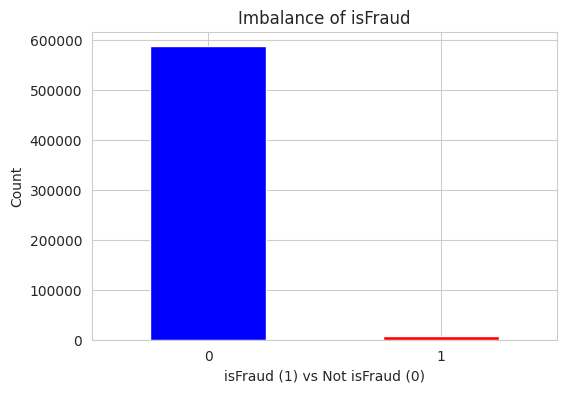

In [14]:
# plot imabalnce of target variable
eda = EDA(df_processed)
eda.plot_imbalance('isFraud')

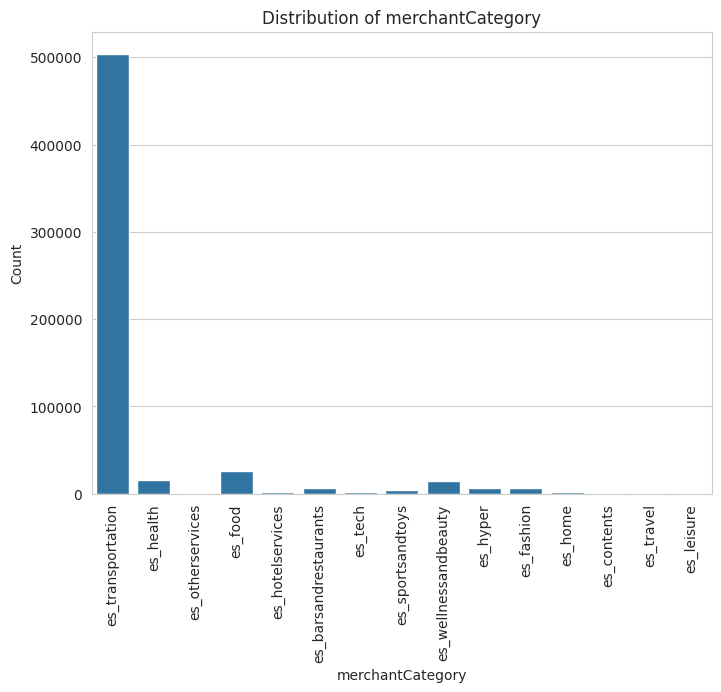

In [ ]:
#Plot categorical distribution for merchantCategory column
eda.plot_categorical_distribution(df_processed, 'merchantCategory')

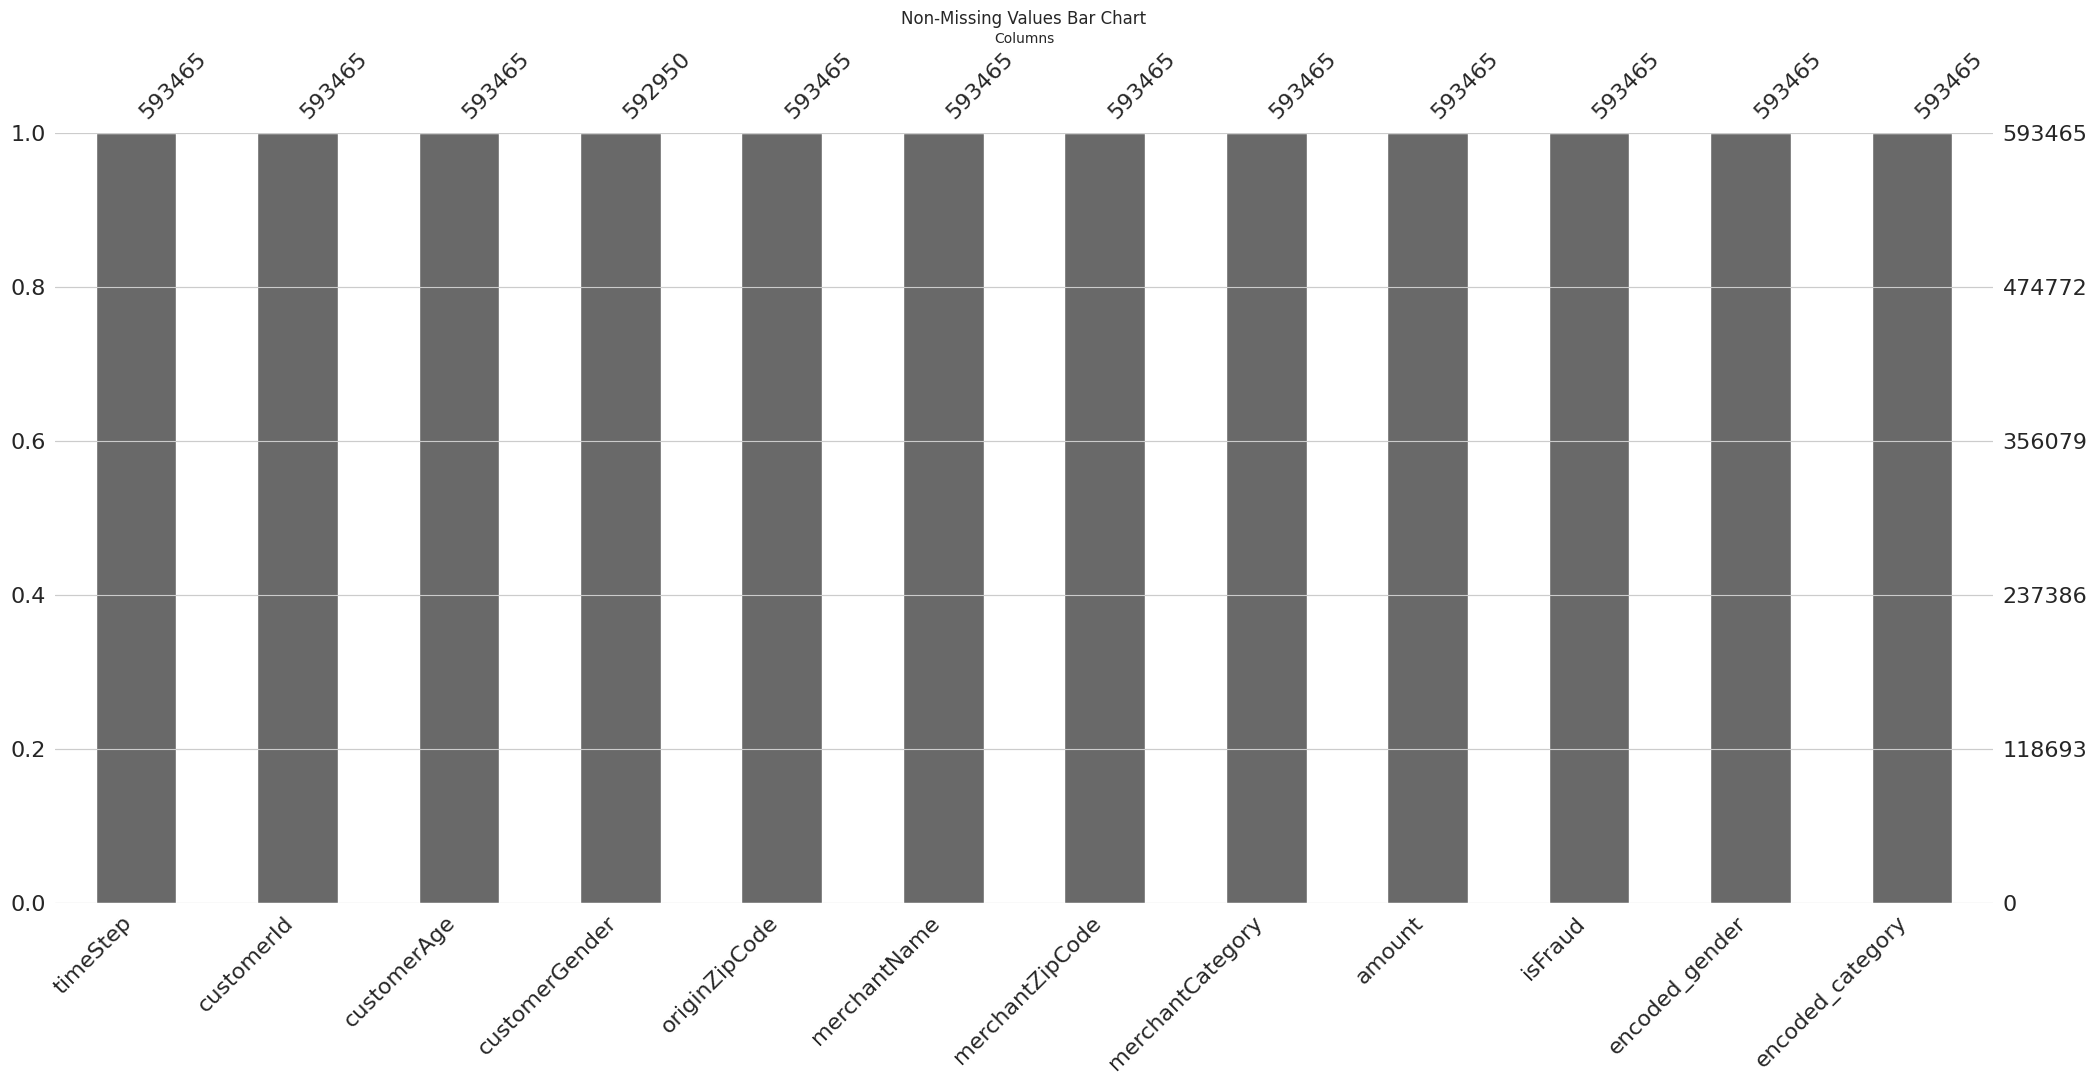

In [ ]:
# Plot non-missing values in the given DataFrame using a bar chart
eda.plot_missing_values_bar(df_processed)

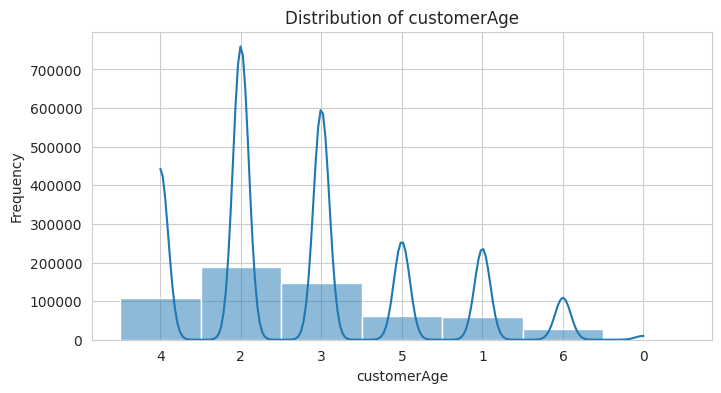

In [ ]:
#Plot the distribution of customer age
eda.plot_customer_age_and_gender_distribution(df_processed, 'customerAge')

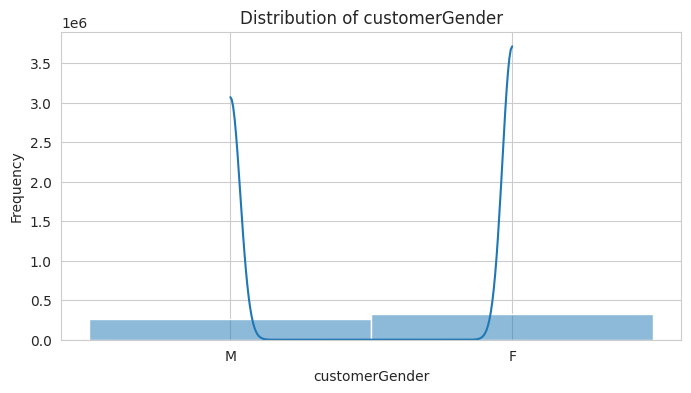

In [ ]:
#Plot the distribution of customer gender
eda.plot_customer_age_and_gender_distribution(df_processed, 'customerGender')

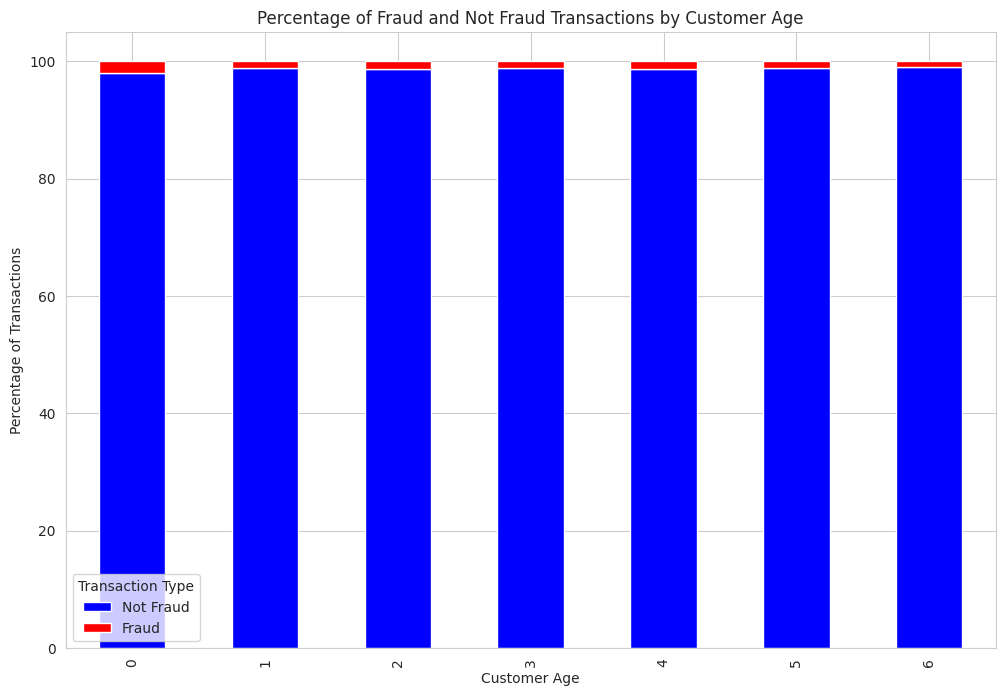

In [ ]:
eda.plot_fraud_percentage_by_age(df_processed, age_column='customerAge')

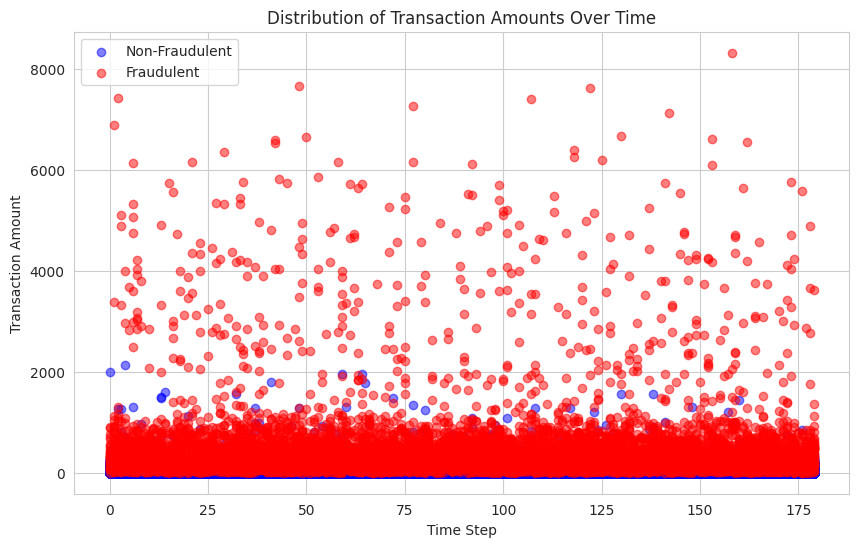

In [ ]:
eda.plot_amount_distribution(df_processed)

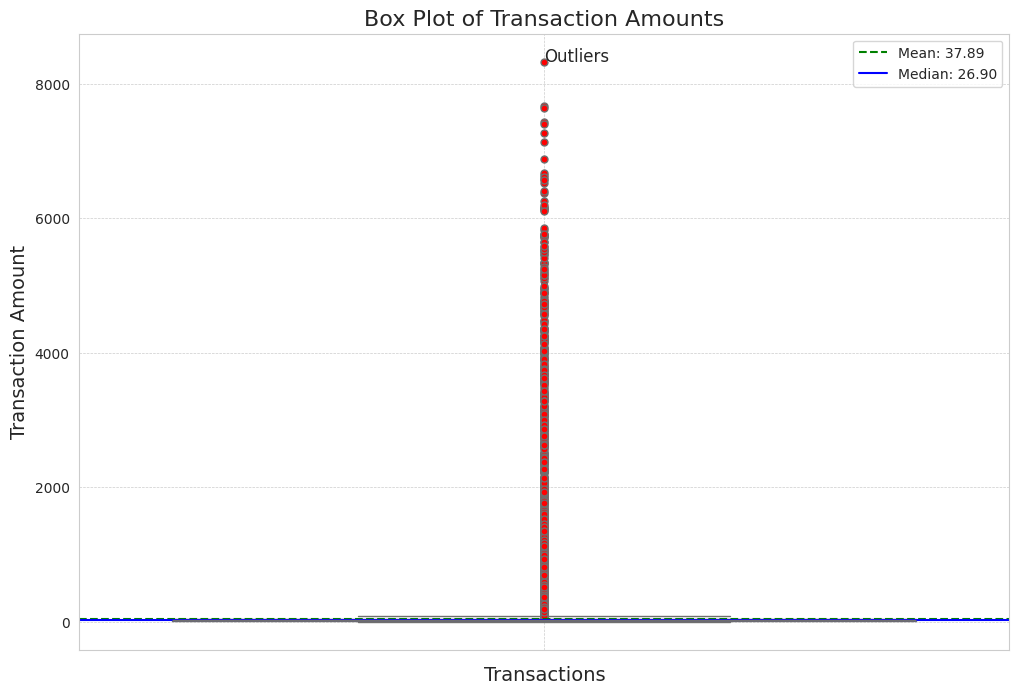

In [ ]:
eda.plot_amount_boxplot(df_processed)

EDA for fraudlent transactions

In [ ]:
df_fraud_trx = df_processed[df_processed['isFraud'] == 1]

In [ ]:
edaFraud = EDA(df_fraud_trx)

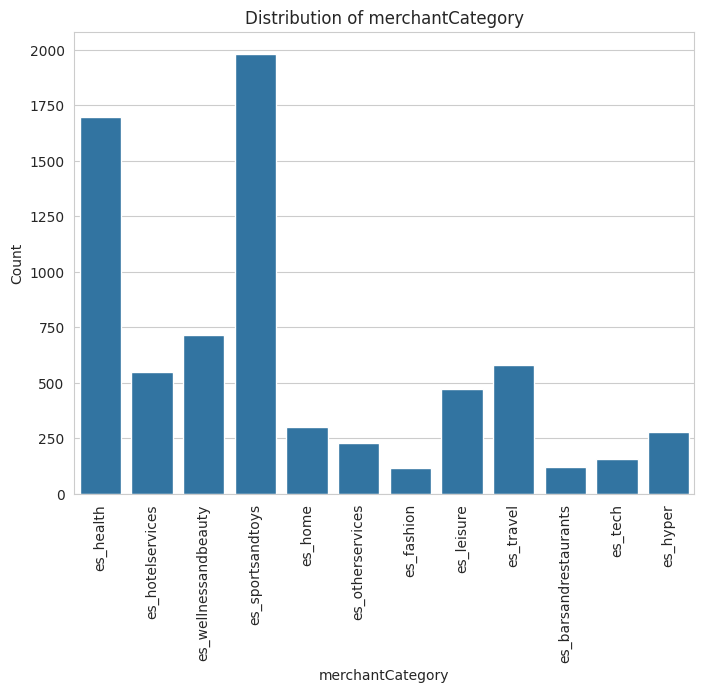

In [ ]:
#Plot categorical distribution for merchantCategory column
edaFraud.plot_categorical_distribution(df_fraud_trx, 'merchantCategory')

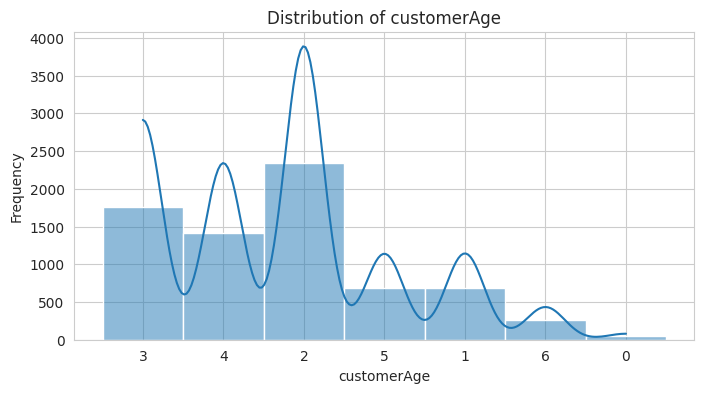

In [ ]:
#Plot the distribution of customer age
edaFraud.plot_customer_age_and_gender_distribution(df_fraud_trx, 'customerAge')

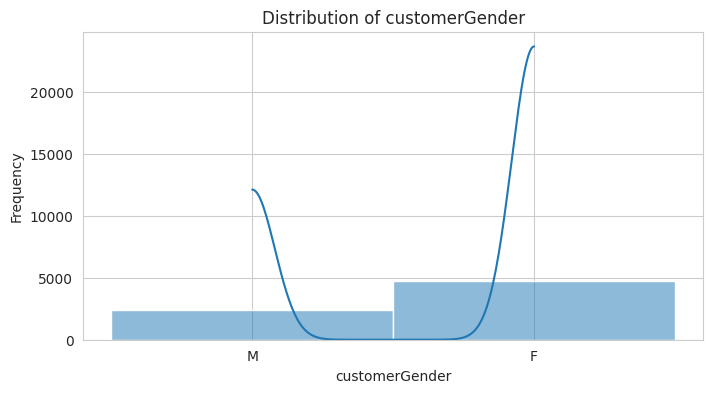

In [ ]:
#Plot the distribution of customer gender
edaFraud.plot_customer_age_and_gender_distribution(df_fraud_trx, 'customerGender')

### Relationships

In [24]:
def plot_filtered_pairplot(df, num_vars, hue_column, palette='viridis', title='Pair Plot'):
    """
    Generate a pair plot for specified numerical variables in the DataFrame.

    Returns:
    None: Displays the pair plot.
    """
    # Convert customerAge to numeric
    df['customerAge'] = pd.to_numeric(df['customerAge'], errors='coerce')

    # Ensure hue_column is categorical
    if not pd.api.types.is_categorical_dtype(df[hue_column]):
        df[hue_column] = df[hue_column].astype('category')

    # Filter DataFrame to include only numerical variables and hue column
    df_filtered = df[num_vars + [hue_column]].dropna()

    # Create the pair plot
    pair_plot = sns.pairplot(df_filtered, vars=num_vars, hue=hue_column, palette=palette)

    # Set the title of the plot
    pair_plot.fig.suptitle(title, y=1.02)

    # Show the plot
    plt.show()

<ipython-input-24-b57e5a07001a>:12: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df[hue_column]):


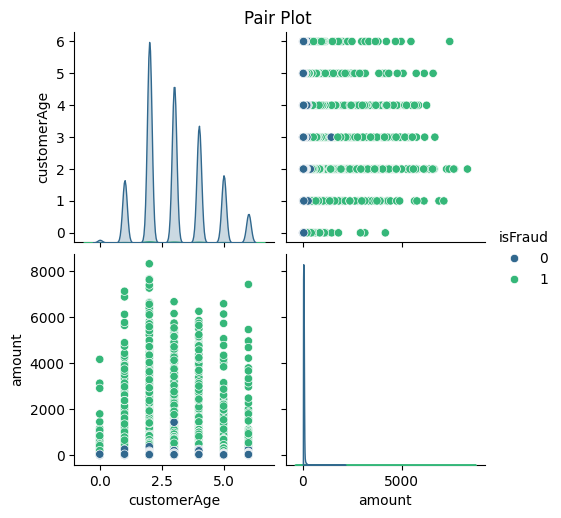

In [25]:
plot_filtered_pairplot(df_processed, num_vars=['customerAge', 'amount'], hue_column='isFraud')

In [26]:
def plot_correlation_heatmap(df, exclude_columns, target_column):
    """
    Create a correlation heatmap for numerical columns in the DataFrame, excluding specified columns.

    Parameters:
    df (pd.DataFrame)
    exclude_columns (list): List of columns to exclude from the correlation calculation (as these are categorical, however these are represented by encoded gender and category columns).
    target_column (str)

    Returns:
    None: Displays the correlation heatmap.
    """
    # Drop excluded columns
    df_filtered = df.drop(columns=exclude_columns)

    # Ensure target_column is categorical
    if not pd.api.types.is_categorical_dtype(df[target_column]):
        df[target_column] = df[target_column].astype('category')

    # Convert categorical target_column to numerical for correlation calculation
    df_filtered[target_column] = df_filtered[target_column].cat.codes

    # Compute the correlation matrix
    correlation_matrix = df_filtered.corr()

    # Create the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Heatmap')
    plt.show()


<ipython-input-26-8c92e775df46>:17: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df[target_column]):


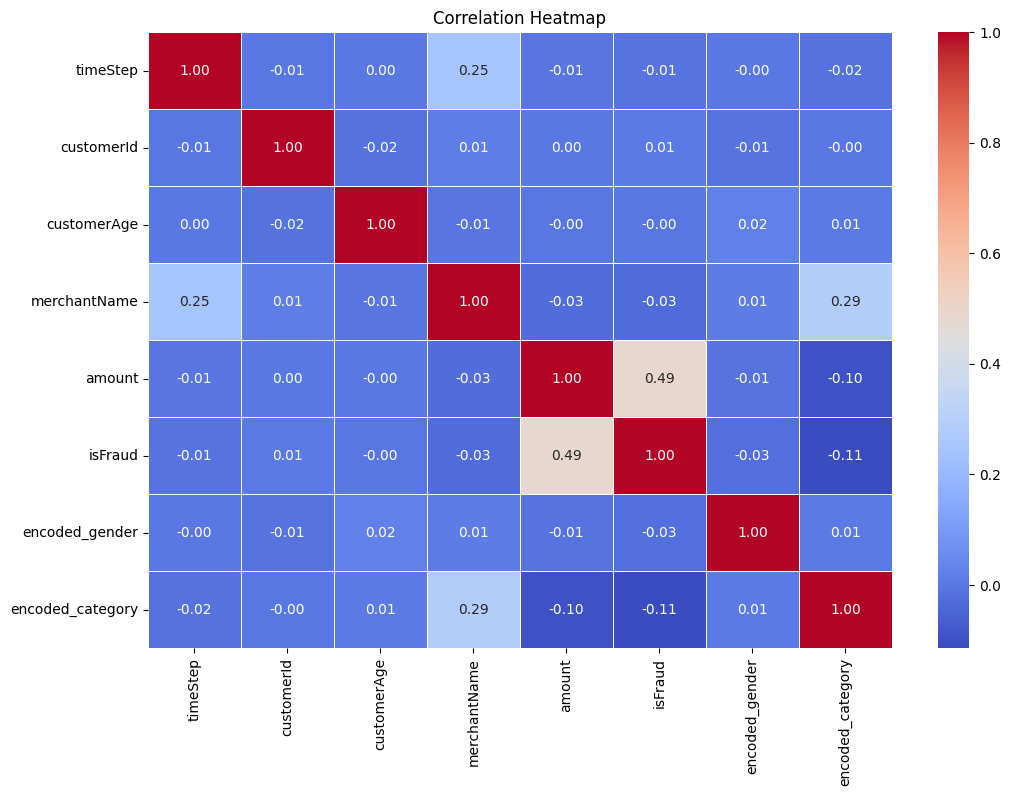

In [27]:
exclude_columns = ['customerGender', 'merchantCategory']
target_column = 'isFraud'
plot_correlation_heatmap(df_processed, exclude_columns, target_column)

### More pre-processing to handle categorical values

In [15]:
df_processed_rag = df_processed.copy()

## Feature Engineering

In [16]:
def process_transactions(df):
    """
    Adds 'IslargeTransaction' and 'countForCustomerSameTime' columns to the DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame

    Returns:
    pd.DataFrame: DataFrame with the new columns added.
    """
    # Add 'IslargeTransaction' column based on the condition
    df['IslargeTransaction'] = df['amount'].apply(lambda x: 1 if x >= 5000 else 0)

    # Calculate the count of transactions for each customer at each time step
    df['countForCustomerSameTime'] = df.groupby(['timeStep', 'customerId'])['customerId'].transform('count')

    return df

def add_avg_transaction_amount(df, customer_id_col='customerId', amount_col='amount'):
    """
    Adds a new column to the DataFrame that contains the average transaction amount
    for each customerId.

    Parameters:
    df (pd.DataFrame): DataFrame
    customer_id_col (str)
    amount_col (str)

    Returns:
    pd.DataFrame: The DataFrame with an added column 'avgTransactionAmount'.
    """
    # Calculate the average transaction amount for each customerId
    avg_transaction_amount = df.groupby(customer_id_col)[amount_col].mean()

    # Map the average transaction amount back to the original DataFrame
    df['avgTransactionAmount'] = df[customer_id_col].map(avg_transaction_amount)

    return df

In [17]:
# Apply the function to process the DataFrame
df_processed = process_transactions(df_processed)
df_processed_rag = process_transactions(df_processed_rag)

In [18]:
df_processed = add_avg_transaction_amount(df_processed)
df_processed_rag = add_avg_transaction_amount(df_processed_rag)


In [19]:
df_processed.head()

,timeStep,customerId,customerAge,customerGender,merchantName,merchantCategory,amount,isFraud,encoded_gender,encoded_category,IslargeTransaction,countForCustomerSameTime,avgTransactionAmount
0,0,1093826151,4,M,348934600,es_transportation,4.55,0,1,12,0,1,28.240719
1,0,352968107,2,M,348934600,es_transportation,39.68,0,1,12,0,1,32.661361
2,0,2054744914,4,F,1823072687,es_transportation,26.89,0,0,12,0,1,41.443692
3,0,1760612790,3,M,348934600,es_transportation,17.25,0,1,12,0,1,30.338772
4,0,757503768,5,M,348934600,es_transportation,35.72,0,1,12,0,1,31.696759


# Baseline models for Fraud Detection

In [20]:
df_processed.dtypes

,0
timeStep,int64
customerId,int64
customerAge,object
customerGender,object
merchantName,int64
merchantCategory,object
amount,float64
isFraud,int64
encoded_gender,int64
encoded_category,int64


## Random Forest Classifier

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

def train_random_forest(df, categorical_columns, target_column='isFraud', test_size=0.25, n_estimators=10, random_state=42):
    """
    Trains a Random Forest classifier and evaluates its performance.

    Returns:
    None
    """
    # Encode categorical features using LabelEncoder
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

    # Define features and target variable
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Initialize the Random Forest Classifier
    rf_clf = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)

    # Train the model
    rf_clf.fit(X_train, y_train)

    # Make predictions
    y_pred = rf_clf.predict(X_test)

    # Evaluate the model
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))


**Experiment 1: RandomForest without oversampling**

In [37]:
# Columns to encode
categorical_columns = ['customerId', 'merchantName', 'customerAge', 'merchantCategory', 'customerGender']

# Call the function to train the Random Forest classifier
train_random_forest(df_processed, categorical_columns)

Accuracy: 0.9962255757681965
Confusion Matrix:
 [[146489    163]
 [   397   1318]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    146652
           1       0.89      0.77      0.82      1715

    accuracy                           1.00    148367
   macro avg       0.94      0.88      0.91    148367
weighted avg       1.00      1.00      1.00    148367



### Addressing Dataset Imbalance

### SMOTE - (Synthetic Minority Over-sampling Technique)

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

class SmoteOverSampling:
    def __init__(self, dataframe, target_column, test_size=0.2, random_state=42):
        """
        Initialize the SmoteOverSampling with the given parameters.

        """
        self.dataframe = dataframe
        self.target_column = target_column
        self.test_size = test_size
        self.random_state = random_state

    def encode_categorical(self):
        """
        Encode categorical features using integer encoding.
        """
        label_encoders = {}
        for column in self.dataframe.select_dtypes(include=['object']).columns:
            label_encoders[column] = LabelEncoder()
            self.dataframe[column] = label_encoders[column].fit_transform(self.dataframe[column])
        self.label_encoders = label_encoders

    def apply_smote(self):
        """
        Apply SMOTE to balance the dataset.
        """
        X = self.dataframe.drop(self.target_column, axis=1)
        y = self.dataframe[self.target_column]

        smote = SMOTE(random_state=self.random_state)
        X_resampled, y_resampled = smote.fit_resample(X, y)

        self.X_resampled = pd.DataFrame(X_resampled, columns=X.columns)
        self.y_resampled = pd.Series(y_resampled, name=self.target_column)

        # Create DataFrame for the original and synthetic samples
        self.df_processed_os = self.X_resampled.copy()
        self.df_processed_os[self.target_column] = self.y_resampled

    def scale_features(self):
        """
        Scale the features using StandardScaler.
        """
        scaler = StandardScaler()
        self.X_resampled_scaled = scaler.fit_transform(self.X_resampled)

    def split_data(self):
        """
        Split the data into training and testing sets.
        """
        X_train, X_test, y_train, y_test = train_test_split(
            self.X_resampled_scaled, self.y_resampled,
            test_size=self.test_size, random_state=self.random_state
        )
        return X_train, X_test, y_train, y_test

In [23]:
# Initialize the preprocessor
preprocessor = SmoteOverSampling(df_processed, target_column='isFraud')

# Encode categorical features
preprocessor.encode_categorical()

# Apply SMOTE to balance the dataset
preprocessor.apply_smote()


df_processed_os = preprocessor.df_processed_os

preprocessor.scale_features()
X_train, X_test, y_train, y_test = preprocessor.split_data()

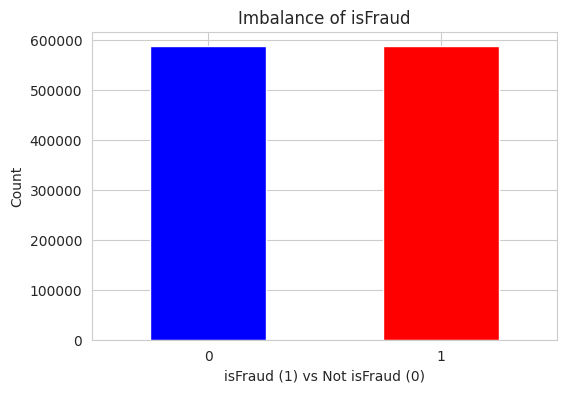

In [24]:
# plot imabalnce of target variable after SMOTE
eda = EDA(df_processed_os)
eda.plot_imbalance('isFraud')

**Experiment 2: RandomForest with oversampled data (SMOTE) and optimization**

In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def train_random_forest(df, categorical_columns, target_column='isFraud', test_size=0.25, n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42):
    """
    Trains a Random Forest classifier and evaluates its performance with optimized hyperparameters.


    Returns:
    None
    """
    # Encode categorical features using LabelEncoder
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

    # Define features and target variable
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Optional: Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Initialize the Random Forest Classifier with additional hyperparameters
    rf_clf = RandomForestClassifier(n_estimators=n_estimators,
                                    max_depth=max_depth,
                                    min_samples_split=min_samples_split,
                                    min_samples_leaf=min_samples_leaf,
                                    random_state=random_state)

    # Train the model
    rf_clf.fit(X_train, y_train)

    # Make predictions
    y_pred = rf_clf.predict(X_test)

    # Evaluate the model
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # Feature importances
    feature_importances = pd.DataFrame(rf_clf.feature_importances_,
                                       index=[f'Feature_{i}' for i in range(X.shape[1])],
                                       columns=['Importance']).sort_values('Importance', ascending=False)
    print("\nFeature Importances:\n", feature_importances)

    # Plot feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y=feature_importances.index, data=feature_importances, palette='viridis')
    plt.title('Feature Importances')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

Accuracy: 0.9963940687485958
Confusion Matrix:
 [[175849    108]
 [   534   1549]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    175957
           1       0.93      0.74      0.83      2083

    accuracy                           1.00    178040
   macro avg       0.97      0.87      0.91    178040
weighted avg       1.00      1.00      1.00    178040


Feature Importances:
             Importance
Feature_6     0.571276
Feature_8     0.119346
Feature_4     0.118488
Feature_5     0.114249
Feature_10    0.036676
Feature_0     0.015670
Feature_1     0.013507
Feature_2     0.004832
Feature_9     0.002202
Feature_7     0.001918
Feature_3     0.001835


<ipython-input-54-0d4830b1d233>:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y=feature_importances.index, data=feature_importances, palette='viridis')


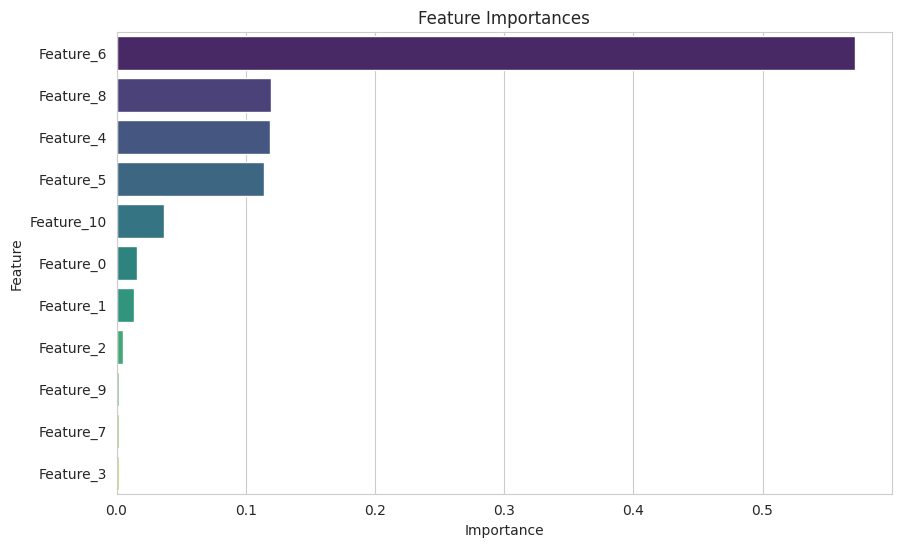

In [55]:
# List of categorical columns
categorical_columns = ['customerGender', 'merchantCategory']

# Call the train_random_forest function
train_random_forest(df_processed,
                    categorical_columns=categorical_columns,
                    target_column='isFraud',
                    test_size=0.3,
                    n_estimators=100,
                    max_depth=10,
                    min_samples_split=2,
                    min_samples_leaf=1,
                    random_state=42)

In [56]:
def visualize_random_forest_tree(df, categorical_columns, target_column='isFraud', test_size=0.25, n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42, tree_index=0):
    """
    Trains a Random Forest classifier and visualizes one of the trees in the forest.

    Returns:
    None
    """
    # Encode categorical features using LabelEncoder
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

    # Define features and target variable
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Optional: Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Initialize the Random Forest Classifier with additional hyperparameters
    rf_clf = RandomForestClassifier(n_estimators=n_estimators,
                                    max_depth=max_depth,
                                    min_samples_split=min_samples_split,
                                    min_samples_leaf=min_samples_leaf,
                                    random_state=random_state)

    # Train the model
    rf_clf.fit(X_train, y_train)

    # Extract one tree from the forest
    tree_clf = rf_clf.estimators_[tree_index]

    # Visualize the tree
    dot_data = export_graphviz(tree_clf, out_file=None,
                               feature_names=df.drop(columns=[target_column]).columns,
                               class_names=['Not Fraud', 'Fraud'],
                               filled=True, rounded=True, special_characters=True)
    graph = graphviz.Source(dot_data)
    graph.render(filename='random_forest_tree', format='png', cleanup=False)  # Save as PNG
    print("Tree visualized and saved as 'random_forest_tree.png'.")

    # Display the tree
    plt.figure(figsize=(20, 15))
    plt.imshow(plt.imread('random_forest_tree.png'))
    plt.axis('off')
    plt.show()

Tree visualized and saved as 'random_forest_tree.png'.


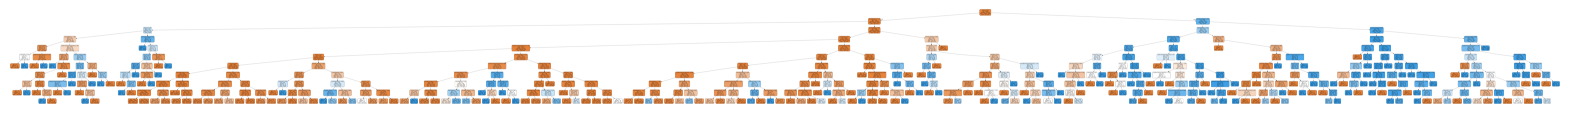

In [58]:
import graphviz
from sklearn.tree import export_graphviz

# List of categorical columns
categorical_columns = ['customerGender', 'merchantCategory']

# Call the function
visualize_random_forest_tree(df_processed,
                              categorical_columns=categorical_columns,
                              target_column='isFraud',
                              test_size=0.3,
                              n_estimators=100,
                              max_depth=10,
                              min_samples_split=2,
                              min_samples_leaf=1,
                              random_state=42,
                              tree_index=0)

# Neural Network

### Experiment 3: on basic neural network model

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

def create_nn_basic_model(input_dim):
    """
    Creates a neural network model.

    Parameters:
    input_dim

    Returns:
    model (Sequential): Compiled neural network model.
    """
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

def train_and_evaluate_nn_basic(df, categorical_columns, target_column='isFraud', test_size=0.25, random_state=42):
    """
    Trains a neural network on the data and evaluates its performance.

    Returns:
    None
    """
    # Define features and target variable
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Create the neural network model
    model = create_nn_model(input_dim=X_train.shape[1])

    # Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

    # Make predictions
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    # Evaluate the model
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [29]:
# Specify categorical columns and target column
categorical_columns = ['customerGender', 'merchantCategory']
target_column = 'isFraud'

# Call the function to train and evaluate the neural network
train_and_evaluate_nn_basic(df_processed, categorical_columns, target_column, test_size=0.25, random_state=42)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11128/11128 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - accuracy: 0.9744 - loss: 385055.8750 - val_accuracy: 0.9879 - val_loss: 30996.5332
Epoch 2/10
11128/11128 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.9744 - loss: 23848.4883 - val_accuracy: 0.9883 - val_loss: 243.1512
Epoch 3/10
11128/11128 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.9862 - loss: 117.5103 - val_accuracy: 0.9879 - val_loss: 0.0654
Epoch 4/10
11128/11128 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - accuracy: 0.9875 - loss: 0.0673 - val_accuracy: 0.9879 - val_loss: 0.0654
Epoch 5/10
11128/11128 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - accuracy: 0.9876 - loss: 0.0668 - val_accuracy: 0.9879 - val_loss: 0.0654
Epoch 6/10
11128/11128 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - accuracy: 0.9879 - loss: 0.0655 - val_accuracy: 0.9879 - val_loss: 0.0654
Epoch 7/10
11128/11128 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - accuracy: 0.9876 - loss: 0.0666 - val_accuracy: 0.9879 - val_loss: 0.0654
Epoch 8/10
11128/11128 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - accu

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Experiment 4:  on optimized neural network model

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def create_nn_model(input_dim):
    """
    Creates a neural network model with dropout layers.

    Parameters:
    input_dim

    Returns:
    model (Sequential): Compiled neural network model.
    """
    model = Sequential()
    model.add(Input(shape=(input_dim,)))  # Define the input shape using Input layer
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))  # Dropout layer with 50% dropout rate
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))  # Dropout layer with 50% dropout rate
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

def train_and_evaluate_nn(df, categorical_columns, target_column='isFraud', test_size=0.25, random_state=42):
    """
    Trains a neural network on the data and evaluates its performance.

    Returns:
    None
    """
    # Convert categorical target variable to numeric
    df[target_column] = LabelEncoder().fit_transform(df[target_column])

    # Encode categorical features using LabelEncoder
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

    # Define features and target variable
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Optional: Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Create the neural network model
    model = create_nn_model(input_dim=X_train.shape[1])

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

    # Make predictions
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    # Evaluate the model
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # Plot training & validation loss and accuracy
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

**Experiment 4.1 : For imbalanced dataset**

Epoch 1/10
11128/11128 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - accuracy: 0.9796 - loss: 0.0635 - val_accuracy: 0.9939 - val_loss: 0.0204
Epoch 2/10
11128/11128 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - accuracy: 0.9934 - loss: 0.0258 - val_accuracy: 0.9942 - val_loss: 0.0196
Epoch 3/10
11128/11128 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - accuracy: 0.9936 - loss: 0.0232 - val_accuracy: 0.9944 - val_loss: 0.0192
Epoch 4/10
11128/11128 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - accuracy: 0.9936 - loss: 0.0233 - val_accuracy: 0.9946 - val_loss: 0.0182
Epoch 5/10
11128/11128 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - accuracy: 0.9936 - loss: 0.0225 - val_accuracy: 0.9946 - val_loss: 0.0180
Epoch 6/10
11128/11128 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - accuracy: 0.9937 - loss: 0.0218 - val_accuracy: 0.9944 - val_loss: 0.0183
Epoch 7/10
11128/11128 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - accuracy: 0.9936 - loss: 0.0220 - val_accuracy: 0.9945 - val_loss: 0.0178
Epoch 8/10
11128/11128 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 

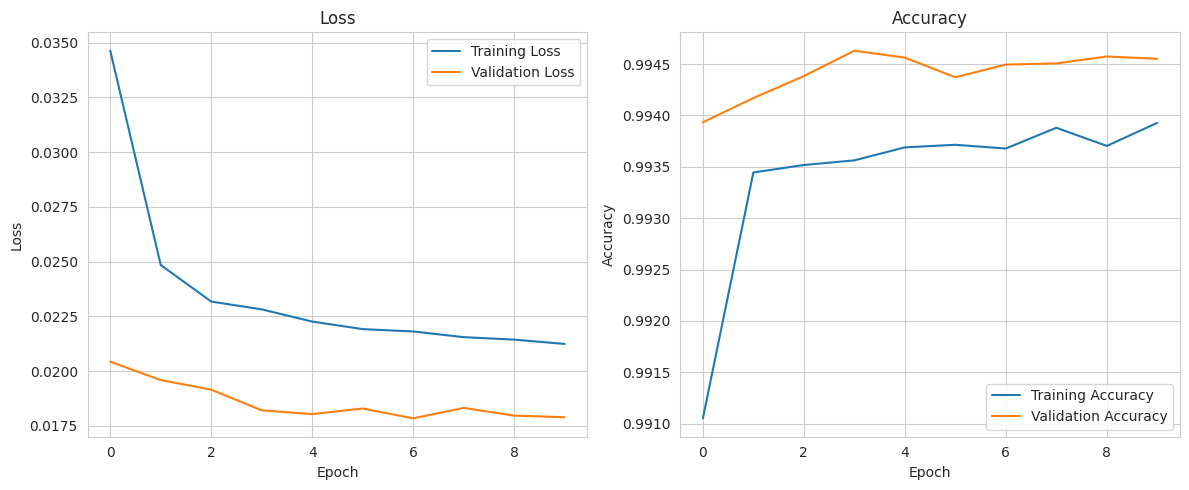

In [68]:
# Specify categorical columns and target column
categorical_columns = ['customerGender', 'merchantCategory']
target_column = 'isFraud'

# Call the function to train and evaluate the neural network
train_and_evaluate_nn(df_processed, categorical_columns, target_column, test_size=0.25, random_state=42)

**Experiment 4.2 : For oversampled dataset**

Epoch 1/10
21986/21986 ━━━━━━━━━━━━━━━━━━━━ 64s 3ms/step - accuracy: 0.9500 - loss: 0.1348 - val_accuracy: 0.9827 - val_loss: 0.0507
Epoch 2/10
21986/21986 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step - accuracy: 0.9778 - loss: 0.0681 - val_accuracy: 0.9837 - val_loss: 0.0478
Epoch 3/10
21986/21986 ━━━━━━━━━━━━━━━━━━━━ 84s 2ms/step - accuracy: 0.9792 - loss: 0.0640 - val_accuracy: 0.9843 - val_loss: 0.0451
Epoch 4/10
21986/21986 ━━━━━━━━━━━━━━━━━━━━ 77s 2ms/step - accuracy: 0.9794 - loss: 0.0620 - val_accuracy: 0.9846 - val_loss: 0.0443
Epoch 5/10
21986/21986 ━━━━━━━━━━━━━━━━━━━━ 81s 2ms/step - accuracy: 0.9803 - loss: 0.0597 - val_accuracy: 0.9853 - val_loss: 0.0441
Epoch 6/10
21986/21986 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step - accuracy: 0.9803 - loss: 0.0594 - val_accuracy: 0.9860 - val_loss: 0.0418
Epoch 7/10
21986/21986 ━━━━━━━━━━━━━━━━━━━━ 79s 2ms/step - accuracy: 0.9808 - loss: 0.0589 - val_accuracy: 0.9863 - val_loss: 0.0405
Epoch 8/10
21986/21986 ━━━━━━━━━━━━━━━━━━━━ 83s 2ms/step - accuracy: 

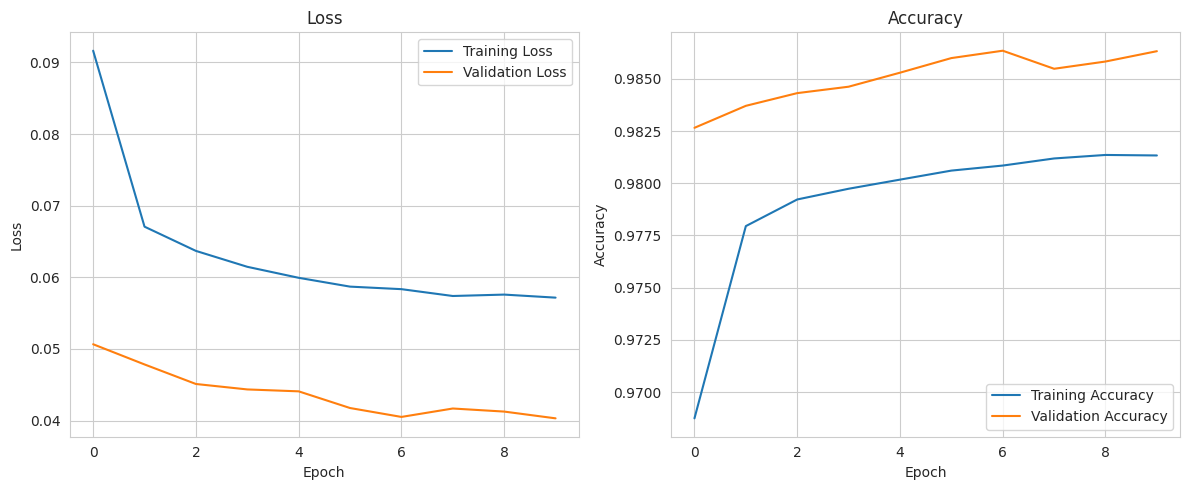

In [25]:
# Specify categorical columns and target column
categorical_columns = ['customerGender', 'merchantCategory']
target_column = 'isFraud'

# Call the function to train and evaluate the neural network
train_and_evaluate_nn(df_processed_os, categorical_columns, target_column, test_size=0.25, random_state=42)

# XGBOOST

In [ ]:
df_processed.head()

,timeStep,customerId,customerAge,customerGender,originZipCode,merchantName,merchantZipCode,merchantCategory,amount,isFraud,IslargeTransaction,countForCustomerSameTime,avgTransactionAmount
0,0,210,4,1,0,30,0,12,4.55,0,0,1,28.240719
1,0,2746,2,1,0,30,0,12,39.68,0,0,1,32.661361
2,0,2280,4,0,0,18,0,12,26.89,0,0,1,41.443692
3,0,1646,3,1,0,30,0,12,17.25,0,0,1,30.338772
4,0,3578,5,1,0,30,0,12,35.72,0,0,1,31.696759


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb

def preprocess_data(df):
    """
    Preprocess the data by splitting into features and target, and performing train-test split.
    :return: X_train, X_test, y_train, y_test
    """
    X = df.drop(columns=['isFraud'])
    y = df['isFraud']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, stratify=y, random_state=42
    )
    return X_train, X_test, y_train, y_test


def build_pipeline():
    """
    Build and return a machine learning pipeline with preprocessing and XGBoost classifier.
    :return: Pipeline
    """
    numeric_features = ['amount', 'customerAge', 'countForCustomerSameTime', 'timeStep', 'avgTransactionAmount']
    categorical_features = ['customerGender', 'merchantName', 'merchantCategory']

    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )

    xgb_model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    )

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', xgb_model)
    ])

    return pipeline


def plot_confusion_matrix(cm, labels):
    """
    Plot the confusion matrix.
    :param cm: Confusion matrix
    :param labels: List of class labels
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


def evaluate_model(pipeline, X_train, X_test, y_train, y_test):
    """
    Train and evaluate the model.
    :param pipeline: Pipeline
    :param X_train: Training features
    :param X_test: Testing features
    :param y_train: Training target
    :param y_test: Testing target
    """
    # Train the model
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)

    # Evaluate the model
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)

    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    print("Classification Report:")
    print(classification_report(y_test, y_pred_test))

    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred_test)
    print(cm)

    # Plot the confusion matrix
    plot_confusion_matrix(cm, labels=['Non-Fraud', 'Fraud'])


def main(df):
    """
    Main function to run the data processing, model training, and evaluation.
    """
    X_train, X_test, y_train, y_test = preprocess_data(df)
    pipeline = build_pipeline()
    evaluate_model(pipeline, X_train, X_test, y_train, y_test)


**Experiment 5: XGBoost (Extreme Gradient Boosting)**

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:33:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Accuracy: 0.9976
Test Accuracy: 0.9968
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    146569
           1       0.91      0.82      0.86      1798

    accuracy                           1.00    148367
   macro avg       0.95      0.91      0.93    148367
weighted avg       1.00      1.00      1.00    148367

Confusion Matrix:
[[146414    155]
 [   317   1481]]


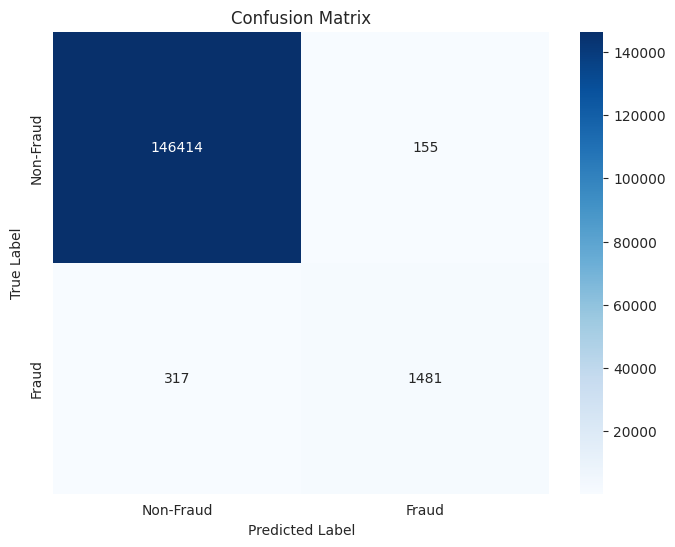

In [36]:
# raw dataset
if __name__ == "__main__":
    main(df_processed)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:34:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Accuracy: 0.9940
Test Accuracy: 0.9934
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    146568
           1       0.99      1.00      0.99    146568

    accuracy                           0.99    293136
   macro avg       0.99      0.99      0.99    293136
weighted avg       0.99      0.99      0.99    293136

Confusion Matrix:
[[145073   1495]
 [   431 146137]]


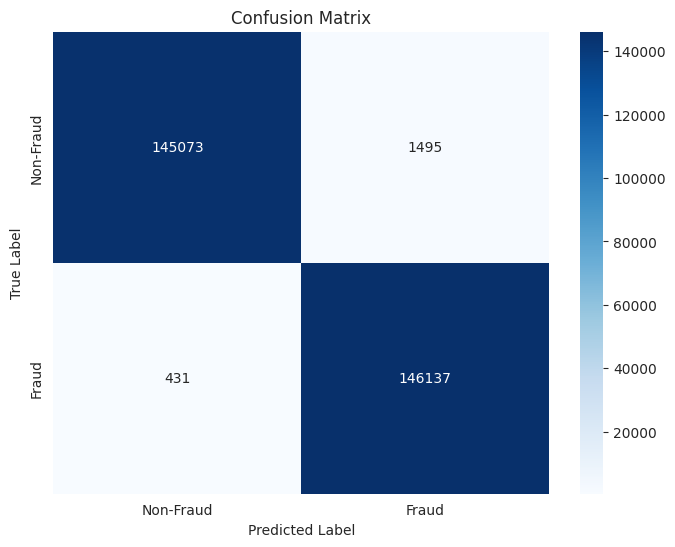

In [37]:
# SMOTE dataset
if __name__ == "__main__":
    main(df_processed_os)

## RAG

In [33]:
import faiss
print(faiss.__version__)

1.7.2


In [55]:
df_processed.dtypes

,0
timeStep,int64
customerId,int64
customerAge,int64
customerGender,int64
merchantName,int64
merchantCategory,int64
amount,float64
isFraud,int64
encoded_gender,int64
encoded_category,int64


# Retrieval Model

In [21]:

import os

# File path to the FAISS index
index_file_path = 'faiss_index.index'

def delete_faiss_index(index_file_path):
    """
    Delete the FAISS index file if it exists.

    """
    if os.path.exists(index_file_path):
        os.remove(index_file_path)
        print(f"FAISS index file {index_file_path} has been deleted.")
    else:
        print(f"FAISS index file {index_file_path} does not exist.")

# Call the function to delete the FAISS index file
delete_faiss_index(index_file_path)


FAISS index file faiss_index.index does not exist.


In [22]:
import numpy as np
import faiss
import pandas as pd
import os

# Assume df_processed is already defined and processed
features = df_processed.drop(columns=['isFraud', 'customerGender', 'merchantCategory'])
embedding_matrix = features.values.astype('float32')

# File path to save/load the FAISS index
index_file_path = 'faiss_index.index'

def create_faiss_index(embedding_matrix, index_file_path):
    """
    Create a FAISS index from the embedding matrix and save it to a file.
    """
    # Ensure the array is C-contiguous
    embedding_matrix = np.ascontiguousarray(embedding_matrix)

    dimension = embedding_matrix.shape[1]
    index = faiss.IndexFlatL2(dimension)  # L2 distance
    index.add(embedding_matrix)  # Add embeddings to the index
    faiss.write_index(index, index_file_path)
    print(f"FAISS index created and saved to {index_file_path}")

def load_faiss_index(index_file_path):
    """
    Load a FAISS index from a file.
    """
    return faiss.read_index(index_file_path)

def get_faiss_index(embedding_matrix, index_file_path):
    """
    Get the FAISS index
    """
    if os.path.exists(index_file_path):
        print(f"Loading FAISS index from {index_file_path}")
        index = load_faiss_index(index_file_path)
    else:
        print(f"FAISS index not found. Creating new index.")
        create_faiss_index(embedding_matrix, index_file_path)
        index = load_faiss_index(index_file_path)
    return index

# Create or load the FAISS index
index = get_faiss_index(embedding_matrix, index_file_path)

def get_similar_transactions(transaction_vector, k=3):
    """
    Retrieve k most similar transactions to the given transaction vector along with their similarity scores

    """
    transaction_vector = np.ascontiguousarray(transaction_vector).astype('float32')
    D, I = index.search(np.array([transaction_vector]), k)
    return I[0], D[0]



FAISS index not found. Creating new index.
FAISS index created and saved to faiss_index.index


In [24]:
transaction_vector = embedding_matrix[88]  # Example transaction vector
similar_indices, similarity_scores = get_similar_transactions(transaction_vector)
print(f"Indices of similar transactions: {similar_indices}")
print(f"Similarity scores (distances): {similarity_scores}")

Indices of similar transactions: [   88  3901 16988]
Similarity scores (distances): [    0.    10995.523 41224.645]


In [25]:
print(df_processed.iloc[88])

timeStep                             0
customerId                   583110837
customerAge                          3
customerGender                       M
merchantName                 480139044
merchantCategory             es_health
amount                           44.26
isFraud                              1
encoded_gender                       1
encoded_category                     4
IslargeTransaction                   0
countForCustomerSameTime             3
avgTransactionAmount        114.287643
Name: 88, dtype: object


In [26]:
print(df_processed.iloc[3901])

timeStep                             1
customerId                   583110837
customerAge                          3
customerGender                       M
merchantName                 480139044
merchantCategory             es_health
amount                          149.11
isFraud                              1
encoded_gender                       1
encoded_category                     4
IslargeTransaction                   0
countForCustomerSameTime             2
avgTransactionAmount        114.287643
Name: 3906, dtype: object


In [27]:
print(df_processed.iloc[16988])

timeStep                             6
customerId                   583110837
customerAge                          3
customerGender                       M
merchantName                 480139044
merchantCategory             es_health
amount                           247.2
isFraud                              0
encoded_gender                       1
encoded_category                     4
IslargeTransaction                   0
countForCustomerSameTime             1
avgTransactionAmount        114.287643
Name: 17015, dtype: object


## Experiment with Text embeddings using Sentence Transformer

In [28]:
df_processed_before = df_processed.copy()

In [29]:
df_processed = df_processed_before.copy()

In [30]:
import pandas as pd

def categorize_amount(amount):
    """
    Categorize the amount into different spending categories.

    Parameters:
    amount (float): The amount to categorize.

    Returns:
    str: The category of the amount.
    """
    if amount < 1:
        return 'low amount'
    elif 1 <= amount < 100:
        return 'intermediate amount'
    elif 100 <= amount < 1000:
        return 'considerable amount'
    elif 1000 <= amount < 5000:
        return 'large amount'
    else:
        return 'hefty amount'

# Apply the categorize_amount function to the 'amount' column
df_processed['bhv_amount'] = df_processed['amount'].apply(categorize_amount)

# Categorize 'countForCustomerSameTime' into 'uncommon transaction' or 'recurring transaction'
df_processed['bhv_frequent'] = df_processed['countForCustomerSameTime'].apply(
    lambda x: 'uncommon transaction' if x == 1 else 'recurring transaction'
)

# Categorize 'isFraud' into 'fraud transaction' or 'genuine transaction'
df_processed['bhv_isFraud'] = df_processed['isFraud'].apply(
    lambda x: 'fraud transaction' if x == 1 else 'genuine transaction'
)

# Categorize 'customerGender' into 'male' or 'female'
df_processed['bhv_gender'] = df_processed['customerGender'].apply(
    lambda x: 'male' if x == 'M' else 'female'
)

# Convert 'customerAge' to numeric, handling errors by coercing to NaN
df_processed['customerAge'] = pd.to_numeric(df_processed['customerAge'], errors='coerce')

def categorize_customer_age(customer_age):
    """
    Categorize the customer age into different age groups.

    Parameters:
    customer_age (float): The customer age to categorize.

    Returns:
    str: The category of the customer age.
    """
    if pd.isna(customer_age):  # Handle NaN values
        return 'Unknown'
    elif customer_age < 2:
        return 'Child'
    elif 2 <= customer_age < 4:
        return 'Teen'
    else:
        return 'Adult'

# Apply the categorize_customer_age function to the 'customerAge' column
df_processed['bhv_customerAge'] = df_processed['customerAge'].apply(categorize_customer_age)


In [31]:
# Create a new column 'transaction_behavior' with optimized string formatting
df_processed['transaction_behavior'] = df_processed.apply(
    lambda row: (
        f"A {row['bhv_frequent']} originated from "
        f"a {row['bhv_customerAge']} {row['bhv_gender']} customer {row['customerId']} "
        f"from merchant {row['merchantName']} "
        f"to category {row['merchantCategory']} "
        f"with {row['bhv_amount']} is categorized as {row['bhv_isFraud']}"
    ),
    axis=1
)

In [68]:
df_processed.tail(5)

,timeStep,customerId,customerAge,customerGender,merchantName,merchantCategory,amount,isFraud,encoded_gender,encoded_category,IslargeTransaction,countForCustomerSameTime,avgTransactionAmount,bhv_amount,bhv_frequent,bhv_isFraud,bhv_gender,bhv_customerAge,transaction_behavior,embeddings
9995,101,665566426,3,F,1823072687,es_transportation,2.14,0,0,12,0,1,35.228188,intermediate amount,uncommon transaction,genuine transaction,female,Teen,A uncommon transaction originated from a Teen ...,"[-0.24622598, -0.064240046, -0.12314938, -0.23..."
9996,25,2020967123,3,M,348934600,es_transportation,9.78,0,1,12,0,1,30.796516,intermediate amount,uncommon transaction,genuine transaction,male,Teen,A uncommon transaction originated from a Teen ...,"[-0.2610166, -0.031317815, -0.1628774, -0.3333..."
9997,152,381007057,1,F,1198415165,es_wellnessandbeauty,189.18,1,0,14,0,1,513.888700,considerable amount,uncommon transaction,fraud transaction,female,Child,A uncommon transaction originated from a Child...,"[-0.3368434, -0.11404773, -0.46481925, -0.1203..."
9998,131,1029994689,3,M,1823072687,es_transportation,5.76,0,1,12,0,1,31.070116,intermediate amount,uncommon transaction,genuine transaction,male,Teen,A uncommon transaction originated from a Teen ...,"[-0.29584515, -0.0036432743, -0.15382703, -0.3..."
9999,37,1398865038,3,F,732195782,es_travel,4076.42,1,0,13,0,2,60.918966,large amount,recurring transaction,fraud transaction,female,Teen,A recurring transaction originated from a Teen...,"[-0.29448354, -0.04154571, -0.3281288, -0.3050..."


## Experiment 6: Embedding method (TF-IDF vs BERT)

In [158]:
# Using TF-IDF Vectorization

from sklearn.feature_extraction.text import TfidfVectorizer

# Sample data
text = ["Transaction Behavior: A uncommon transaction originated from Adult male customer 1038277619 from merchant 980657600 to category sportsandtoys with considerable amount is categorized as fraud transaction."]

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the data
tfidf_matrix = vectorizer.fit_transform(text)

# Convert the TF-IDF matrix to an array
tfidf_vector = tfidf_matrix.toarray()

print('Input Text :', text)
print('Empbedding Vector Shape :', tfidf_vector.shape)
print('Empbedding :', tfidf_vector)


Input Text : ['Transaction Behavior: A uncommon transaction originated from Adult male customer 1038277619 from merchant 980657600 to category sportsandtoys with considerable amount is categorized as fraud transaction.']
Empbedding Vector Shape : (1, 21)
Empbedding : [[0.1767767  0.1767767  0.1767767  0.1767767  0.1767767  0.1767767
  0.1767767  0.1767767  0.1767767  0.1767767  0.1767767  0.35355339
  0.1767767  0.1767767  0.1767767  0.1767767  0.1767767  0.1767767
  0.53033009 0.1767767  0.1767767 ]]


In [157]:
# Using Transformer Models (e.g., BERT)

from transformers import BertTokenizer, BertModel
import torch

# Load pre-trained model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Sample data
text = ["Transaction Behavior: A uncommon transaction originated from Adult male customer 1038277619 from merchant 980657600 to category sportsandtoys with considerable amount is categorized as fraud transaction."]

# Tokenize and encode the text
inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)

# Forward pass to get embeddings
with torch.no_grad():
    outputs = model(**inputs)

# Get the embeddings (use the last hidden state or pooled output)
embeddings = outputs.last_hidden_state.mean(dim=1).numpy()

print('Input Text :', text)

print('Empbedding Vector Shape :', embeddings.shape)
print('Empbedding :', embeddings)

Input Text : ['Transaction Behavior: A uncommon transaction originated from Adult male customer 1038277619 from merchant 980657600 to category sportsandtoys with considerable amount is categorized as fraud transaction.']
Empbedding Vector Shape : (1, 768)
Empbedding : [[-2.04235077e-01 -1.18124530e-01  2.63644338e-01 -6.16506673e-02
   4.33128297e-01 -1.15664400e-01  2.84973830e-01  7.95875937e-02
  -7.31029883e-02  2.00866088e-02 -8.47476125e-02 -2.44745299e-01
   7.73336217e-02  3.81788671e-01 -4.06664073e-01  3.00855786e-01
   1.07885338e-01  1.28784001e-01 -3.15052301e-01  6.26962930e-02
   9.92494673e-02 -6.90303519e-02  2.96023846e-01  8.69439840e-02
   3.46210629e-01  6.09876886e-02  3.82764675e-02 -3.59539166e-02
  -4.58156079e-01 -4.28357162e-02  7.03518629e-01  3.63010585e-01
   1.55987248e-01 -2.98625797e-01 -1.05050400e-01 -8.54200870e-02
  -9.92375314e-02 -3.34800661e-01 -1.88551664e-01  5.67635223e-02
  -2.43744388e-01 -1.11451335e-01 -2.04137221e-01  1.62768021e-01
   4.

In [69]:
import pandas as pd

# Ensure that df_processed is not empty and has the expected columns
if df_processed is None or 'isFraud' not in df_processed.columns:
    raise ValueError("DataFrame is not loaded properly or missing 'isFraud' column")

# Filter the DataFrame based on isFraud values
fraud_records = df_processed[df_processed['isFraud'] == 1]
non_fraud_records = df_processed[df_processed['isFraud'] == 0]

# Calculate the number of records needed
total_records = 10000
fraud_percentage = 0.20
fraud_needed = int(total_records * fraud_percentage)
non_fraud_needed = total_records - fraud_needed

# Sample the required number of records
fraud_sample = fraud_records.sample(n=fraud_needed, random_state=1)
non_fraud_sample = non_fraud_records.sample(n=non_fraud_needed, random_state=1)

# Combine the sampled data
df_subset = pd.concat([fraud_sample, non_fraud_sample], ignore_index=True)

# Shuffle the DataFrame to randomize the order
df_subset = df_subset.sample(frac=1, random_state=1).reset_index(drop=True)

In [36]:
df_before_subset = df_processed.copy()

In [37]:
df_processed = df_before_subset.copy()

In [82]:
df_subset.head(3)

,timeStep,customerId,customerAge,customerGender,merchantName,merchantCategory,amount,isFraud,encoded_gender,encoded_category,IslargeTransaction,countForCustomerSameTime,avgTransactionAmount,bhv_amount,bhv_frequent,bhv_isFraud,bhv_gender,bhv_customerAge,transaction_behavior,embeddings
0,176,11116138,2,F,1823072687,es_transportation,18.70,0,0,12,0,1,31.868982,intermediate amount,uncommon transaction,genuine transaction,female,Teen,A uncommon transaction originated from a Teen ...,"[-0.32320443, -0.018780287, -0.13238902, -0.23..."
1,138,1524407626,1,M,1823072687,es_transportation,18.73,0,1,12,0,1,31.416136,intermediate amount,uncommon transaction,genuine transaction,male,Child,A uncommon transaction originated from a Child...,"[-0.32463798, -0.07607587, -0.264771, -0.22706..."
2,142,1755124222,2,M,1823072687,es_transportation,10.29,0,1,12,0,1,28.704654,intermediate amount,uncommon transaction,genuine transaction,male,Teen,A uncommon transaction originated from a Teen ...,"[-0.2751433, 0.03041155, -0.13669442, -0.31676..."


In [168]:
# Shaping this dataframe for below experiment
df_test = df_subset.drop('embeddings', axis = 1)

## Experinment: Falg anomalous transactions using embedings

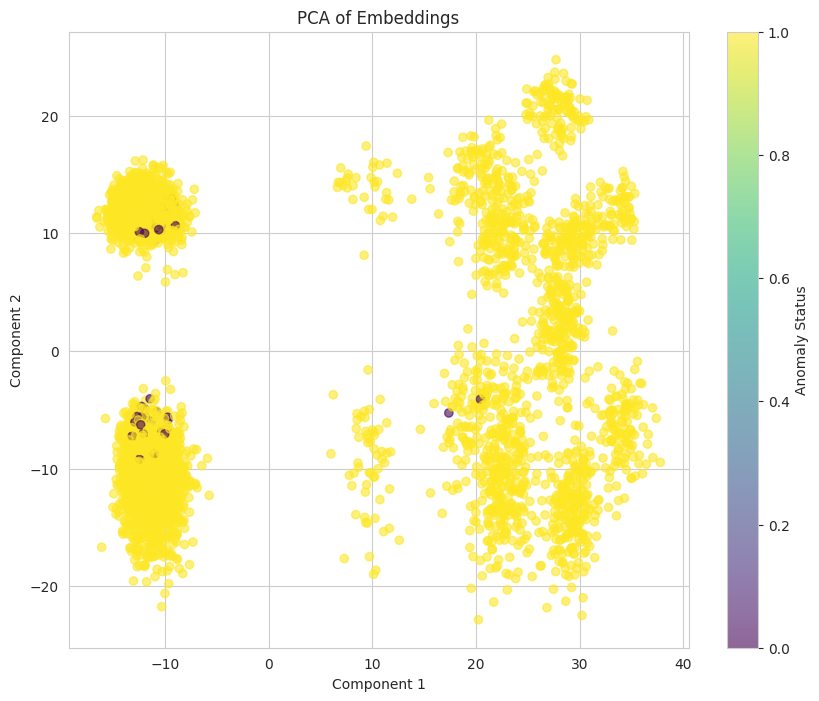

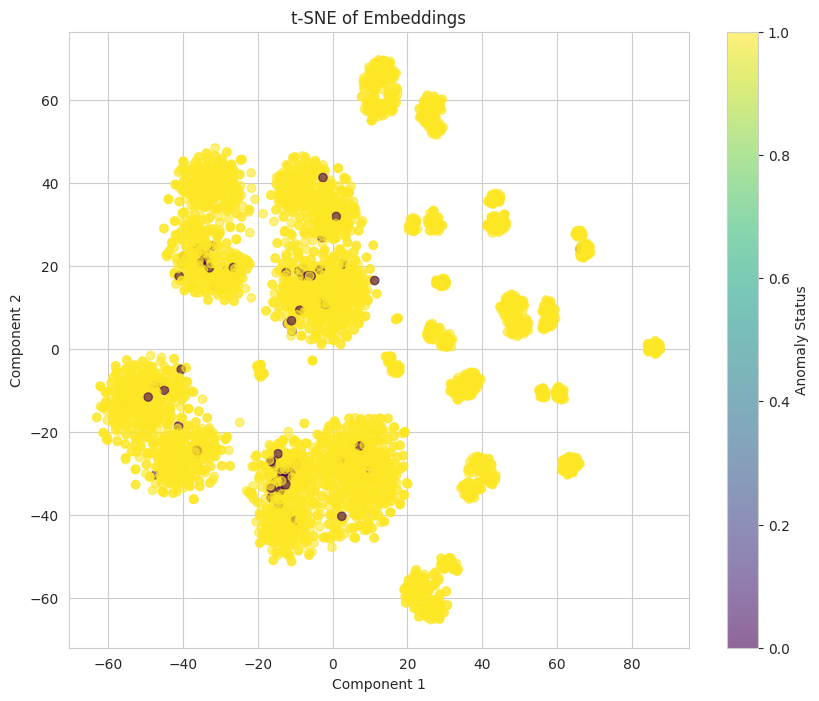

Summary dictionary structure:
Random Forest Approach:
  accuracy: 0.9826
  precision: 0.9323308270676691
  recall: 0.9851042701092354
  f1: 0.9579913085465958
  Unique Anomalies: 18

Embedding-Cosine Approach:
  accuracy: 0.2076
  precision: 0.2006079027355623
  recall: 0.9831181727904668
  f1: 0.3332211376640862
  Unique Anomalies: 3889

Embedding-Euclidean Approach:
  accuracy: 0.215
  precision: 0.20309320309320308
  recall: 0.9910625620655412
  f1: 0.3371052187130552
  Unique Anomalies: 47

Matched Anomalies: 1046



In [169]:
import pandas as pd
import numpy as np
import datetime
import os
import concurrent.futures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
import openai
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.spatial.distance import pdist, squareform
import datetime

# Set OpenAI API Key
os.environ["OPENAI_API_KEY"] = #api-key-here
openai.api_key = os.getenv("OPENAI_API_KEY")

def preprocess_data(df):
    numerical_columns = ['amount', 'avgTransactionAmount', 'timeStep', 'merchantName', 'customerId', 'IslargeTransaction', 'countForCustomerSameTime']
    features = df[numerical_columns].copy()

    # One-hot encoding
    features = pd.concat([features, pd.get_dummies(df['merchantCategory'])], axis=1)
    features = pd.concat([features, pd.get_dummies(df['customerGender'])], axis=1)

    return features

def train_test_split_data(features, labels):
    return train_test_split(features, labels, test_size=0.5, random_state=42)

def scale_features(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

def handle_imbalanced_data(X_train_scaled, y_train):
    smote = SMOTE(random_state=42)
    return smote.fit_resample(X_train_scaled, y_train)

def train_random_forest(X_train_smote, y_train_smote):
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train_smote, y_train_smote)
    return rf_model

def evaluate_model(model, X_test_scaled, y_test):
    y_pred = model.predict(X_test_scaled)
    return {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "conf_matrix": confusion_matrix(y_test, y_pred)
    }

def get_embeddings_parallel(texts):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [executor.submit(get_single_embedding, text) for text in texts]
        return [future.result() for future in concurrent.futures.as_completed(futures)]

def get_single_embedding(text):
    response = openai.Embedding.create(model="text-embedding-ada-002", input=text)
    return response['data'][0]['embedding']

def process_embeddings(df_test):
    if os.path.exists('embeddings_test.npy'):
      embeddings_array = np.load('embeddings_test.npy')
    else:
      df_test = df_test.fillna('').astype(str)
      df_test['combined'] = df_test.apply(lambda row: ' '.join(row), axis=1)

      combined_texts = df_test['combined'].tolist()
      embeddings_list = get_embeddings_parallel(combined_texts)
      embeddings_array = np.array([np.array(embedding).flatten() for embedding in embeddings_list])
      np.save('embeddings_test.npy', embeddings_array)

    return embeddings_array

def normalize_embeddings(embeddings_array):
    scaler = StandardScaler()
    return scaler.fit_transform(embeddings_array)

def calculate_dissimilarity(embeddings_array):
    cosine_dissimilarity_matrix = squareform(pdist(embeddings_array, 'cosine'))
    euclidean_distance_matrix = squareform(pdist(embeddings_array, 'euclidean'))
    return cosine_dissimilarity_matrix, euclidean_distance_matrix

def find_anomalies(distance_matrix, threshold):
    anomaly_indices = np.where(distance_matrix > threshold)
    anomaly_transactions = set()
    for i, j in zip(*anomaly_indices):
        if i != j:
            anomaly_transactions.add(i)
            anomaly_transactions.add(j)
    return anomaly_transactions

def add_anomaly_column(df_test, anomaly_indices, column_name):
    index_mapping = df_test.index.tolist()
    mapped_anomaly_indices = [index_mapping[i] for i in anomaly_indices]
    df_test[column_name] = 0
    df_test.loc[mapped_anomaly_indices, column_name] = 1

def calculate_metrics(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0)
    }

def compare_anomalies(df_test, X_test, rf_predictions):
    embedding_anomalies = set(df_test.loc[X_test.index, 'embedding_cosine_isAnomaly'][df_test.loc[X_test.index, 'embedding_cosine_isAnomaly'] == 1].index)
    euclidean_anomalies = set(df_test.loc[X_test.index, 'embedding_euclidean_isAnomaly'][df_test.loc[X_test.index, 'embedding_euclidean_isAnomaly'] == 1].index)
    rf_anomalies = set(X_test.index[rf_predictions == 1])

    matched_anomalies = embedding_anomalies.intersection(rf_anomalies)
    unique_to_embeddings = embedding_anomalies - rf_anomalies
    unique_to_rf = rf_anomalies - embedding_anomalies
    unique_to_euclidean = euclidean_anomalies - rf_anomalies - embedding_anomalies

    return {
        "matched_anomalies": len(matched_anomalies),
        "unique_to_embeddings": len(unique_to_embeddings),
        "unique_to_rf": len(unique_to_rf),
        "unique_to_euclidean": len(unique_to_euclidean)
    }

def generate_summary_report(rf_metrics, embedding_metrics, euclidean_metrics, comparison):
    summary = {
        "Random Forest Approach": {**rf_metrics, "Unique Anomalies": comparison.get("unique_to_rf", 0)},
        "Embedding-Cosine Approach": {**embedding_metrics, "Unique Anomalies": comparison.get("unique_to_embeddings", 0)},
        "Embedding-Euclidean Approach": {**euclidean_metrics, "Unique Anomalies": comparison.get("unique_to_euclidean", 0)},
        "Matched Anomalies": comparison.get("matched_anomalies", 0)
    }

    # Debugging output to check the structure of summary
    print("Summary dictionary structure:")
    for approach, metrics in summary.items():
        if isinstance(metrics, dict):
            print(f"{approach}:")
            for metric, value in metrics.items():
                print(f"  {metric}: {value}")
        else:
            print(f"{approach}: {metrics}")
        print()

# Functions for dimensionality reduction and visualization
def reduce_dimensions(embeddings_array, method='PCA', n_components=2):
    if method == 'PCA':
        reducer = PCA(n_components=n_components)
    elif method == 't-SNE':
        reducer = TSNE(n_components=n_components, random_state=42)
    else:
        raise ValueError("Method should be either 'PCA' or 't-SNE'")

    return reducer.fit_transform(embeddings_array)

def plot_embeddings(embeddings_reduced, labels, title):
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings_reduced[:, 0], embeddings_reduced[:, 1], c=labels, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter, label='Anomaly Status')
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

def visualize_embeddings(embeddings_array, df_test):
    # Reduce dimensionality using PCA
    embeddings_pca = reduce_dimensions(embeddings_array, method='PCA')
    plot_embeddings(embeddings_pca, df_test['embedding_euclidean_isAnomaly'], 'PCA of Embeddings')

    # Reduce dimensionality using t-SNE
    embeddings_tsne = reduce_dimensions(embeddings_array, method='t-SNE')
    plot_embeddings(embeddings_tsne, df_test['embedding_euclidean_isAnomaly'], 't-SNE of Embeddings')
def main(df):
    # Preprocess data
    features = preprocess_data(df)
    labels = df['isFraud']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split_data(features, labels)

    # Scale features
    X_train_scaled, X_test_scaled = scale_features(X_train, X_test)

    # Handle imbalanced data
    X_train_smote, y_train_smote = handle_imbalanced_data(X_train_scaled, y_train)

    # Train Random Forest model
    rf_model = train_random_forest(X_train_smote, y_train_smote)

    # Evaluate Random Forest model
    rf_predictions = rf_model.predict(X_test_scaled)
    df_test = df.loc[X_test.index]
    df_test['rf_isAnomaly'] = rf_predictions
    rf_metrics = calculate_metrics(y_test, rf_predictions)

    # Process embeddings
    embeddings_array = process_embeddings(df_test)
    normalized_embeddings = normalize_embeddings(embeddings_array)

    # Calculate dissimilarity
    cosine_dissimilarity_matrix, euclidean_distance_matrix = calculate_dissimilarity(normalized_embeddings)

    # Detect anomalies using cosine dissimilarity
    mean_cosine = np.mean(cosine_dissimilarity_matrix)
    std_cosine = np.std(cosine_dissimilarity_matrix)
    threshold_cosine = mean_cosine + 1.5 * std_cosine
    cosine_anomalies = find_anomalies(cosine_dissimilarity_matrix, threshold_cosine)
    add_anomaly_column(df_test, cosine_anomalies, 'embedding_cosine_isAnomaly')

    # Detect anomalies using Euclidean distance
    mean_euclidean = np.mean(euclidean_distance_matrix)
    std_euclidean = np.std(euclidean_distance_matrix)
    threshold_euclidean = mean_euclidean + 1.5 * std_euclidean
    euclidean_anomalies = find_anomalies(euclidean_distance_matrix, threshold_euclidean)
    add_anomaly_column(df_test, euclidean_anomalies, 'embedding_euclidean_isAnomaly')

    # Visualize embeddings
    visualize_embeddings(normalized_embeddings, df_test)

    # Evaluate embedding-based anomaly detection
    embedding_predictions = df_test.loc[X_test.index, 'embedding_cosine_isAnomaly']
    embedding_metrics = calculate_metrics(y_test, embedding_predictions)

    euclidean_predictions = df_test.loc[X_test.index, 'embedding_euclidean_isAnomaly']
    euclidean_metrics = calculate_metrics(y_test, euclidean_predictions)

    # Compare anomalies
    comparison = compare_anomalies(df_test, X_test, rf_predictions)

    # Generate summary report
    generate_summary_report(rf_metrics, embedding_metrics, euclidean_metrics, comparison)

    # Save results
    df_test.to_csv('transactions_with_anomalies.csv', index=False)

if __name__ == "__main__":
    main(df_test)


In [171]:
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
import faiss


def load_model(model_name: str = 'paraphrase-MiniLM-L6-v2') -> SentenceTransformer:
    """
    Load and return the SentenceTransformer model
    """
    return SentenceTransformer(model_name)


def generate_embeddings(df: pd.DataFrame, column: str, model: SentenceTransformer) -> pd.DataFrame:
    """
    Generate embeddings for a specific column in the DataFrame
    """
    df['embeddings'] = df[column].apply(lambda x: model.encode(x))
    return df


def initialize_faiss_index(embeddings: np.ndarray) -> faiss.IndexFlatL2:
    """
    Initialize and return a FAISS index
    """
    dimension = embeddings.shape[1]
    index = faiss.IndexFlatL2(dimension)
    index.add(embeddings)
    return index


def save_faiss_index(index: faiss.IndexFlatL2, filepath: str):
    """
    Save the FAISS index to disk
    """
    faiss.write_index(index, filepath)


def search_similar_transactions(query: str, model: SentenceTransformer, index: faiss.IndexFlatL2,
                                df: pd.DataFrame, k: int = 3) -> dict:
    """
    Search for similar transactions based on the query and return results

    """
    query_embedding = model.encode(query)
    D, I = index.search(np.array([query_embedding]), k)

    # Collect results
    top_k_results = []
    for idx, dist in zip(I[0], D[0]):
        result = {
            'transaction_behavior': df.iloc[idx]['transaction_behavior'],
            'similarity_score': 1 / (1 + dist)  # Convert distance to similarity score
        }
        top_k_results.append(result)

    # Extract the last 2 words of the highest similarity transaction
    highest_similarity_transaction = top_k_results[0]['transaction_behavior']
    prediction = ' '.join(highest_similarity_transaction.split()[-2:])

    return {
        'top_k_results': top_k_results,
        'prediction': prediction
    }


def display_results(results: dict):
    """
    Display the search results and prediction
    """
    print("Top K Results:")
    for i, res in enumerate(results['top_k_results']):
        print(f"Result {i+1}:")
        print(f"Transaction Behavior: {res['transaction_behavior']}")
        print(f"Similarity Score: {res['similarity_score']:.4f}")
        print("-" * 80)

    print("Prediction :")
    print("This transaction is a ", results['prediction'])



In [172]:
if __name__ == "__main__":
    # Load model
    model = load_model()

    # Generate embeddings and add to DataFrame
    df_processed = generate_embeddings(df_processed, 'transaction_behavior', model)

    # Prepare embeddings and initialize FAISS index
    embeddings = np.vstack(df_processed['embeddings'].values)
    index = initialize_faiss_index(embeddings)

    # SAVE the index
    save_faiss_index(index, "faiss_index_2.index")

In [173]:
df_processed[['transaction_behavior', 'embeddings']]

,transaction_behavior,embeddings
0,A uncommon transaction originated from a Child...,"[-0.26773375, -0.1364945, -0.24249536, -0.1612..."
1,A uncommon transaction originated from a Teen ...,"[-0.28429025, -0.072559334, -0.13180217, -0.24..."
2,A uncommon transaction originated from a Teen ...,"[-0.2935935, -0.017920239, -0.16740844, -0.366..."
3,A uncommon transaction originated from a Child...,"[-0.30968127, -0.13049255, -0.28075024, -0.274..."
4,A uncommon transaction originated from a Teen ...,"[-0.3000916, -0.043073166, -0.07285238, -0.226..."
...,...,...
9995,A uncommon transaction originated from a Teen ...,"[-0.24622598, -0.064240046, -0.12314938, -0.23..."
9996,A uncommon transaction originated from a Teen ...,"[-0.2610166, -0.031317815, -0.1628774, -0.3333..."
9997,A uncommon transaction originated from a Child...,"[-0.3368434, -0.11404773, -0.46481925, -0.1203..."
9998,A uncommon transaction originated from a Teen ...,"[-0.29584515, -0.0036432743, -0.15382703, -0.3..."


In [174]:
# Perform search with a query
query2 = "A uncommon transaction .. from a Teen male customer 976805632 .. category es_travel with large amount"
results = search_similar_transactions(query2, model, index, df_subset)

# Display the search results
display_results(results)

Top K Results:
Result 1:
Transaction Behavior: A uncommon transaction originated from a Child female customer 1475317372 from merchant 980657600 to category es_sportsandtoys with considerable amount is categorized as fraud transaction
Similarity Score: 0.0834
--------------------------------------------------------------------------------
Result 2:
Transaction Behavior: A recurring transaction originated from a Teen female customer 1338125837 from merchant 1888755466 to category es_otherservices with considerable amount is categorized as fraud transaction
Similarity Score: 0.0810
--------------------------------------------------------------------------------
Result 3:
Transaction Behavior: A uncommon transaction originated from a Adult male customer 2105324799 from merchant 855959430 to category es_hyper with intermediate amount is categorized as fraud transaction
Similarity Score: 0.0806
--------------------------------------------------------------------------------
Prediction :
Thi

In [175]:
# Perform search with a query
query2 = "A uncommon transaction .. Child female customer 1035222482 from merchant 348934600 to category es_transportation with intermediate"
results = search_similar_transactions(query2, model, index, df_subset)

# Display the search results
display_results(results)

Top K Results:
Result 1:
Transaction Behavior: A uncommon transaction originated from a Adult male customer 2049000934 from merchant 348934600 to category es_transportation with intermediate amount is categorized as genuine transaction
Similarity Score: 0.1244
--------------------------------------------------------------------------------
Result 2:
Transaction Behavior: A uncommon transaction originated from a Teen male customer 1921196241 from merchant 348934600 to category es_transportation with intermediate amount is categorized as genuine transaction
Similarity Score: 0.1242
--------------------------------------------------------------------------------
Result 3:
Transaction Behavior: A uncommon transaction originated from a Teen female customer 789852022 from merchant 1823072687 to category es_transportation with intermediate amount is categorized as genuine transaction
Similarity Score: 0.1240
--------------------------------------------------------------------------------
Pred

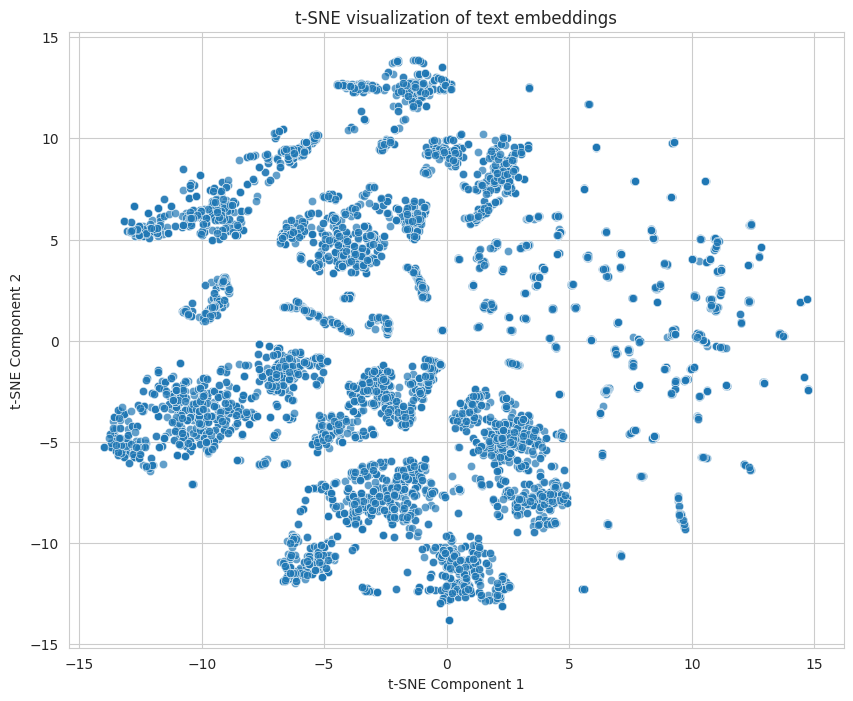

In [176]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

# Perform PCA for dimensionality reduction to 2D
pca = PCA(n_components=50)
pca_result = pca.fit_transform(embeddings)

# Perform t-SNE for further dimensionality reduction to 2D
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_result = tsne.fit_transform(pca_result)

# Plotting the t-SNE result
plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], alpha=0.7)
plt.title('t-SNE visualization of text embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


In [177]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

def evaluate_model(df: pd.DataFrame, model: SentenceTransformer, index: faiss.IndexFlatL2, queries: list, true_labels: list) -> dict:
    """
    Evaluate the model's performance on a set of queries
    """
    predictions = []
    actual_labels = []

    for query, true_label in zip(queries, true_labels):
        results = search_similar_transactions(query, model, index, df)
        predicted_label = results['prediction']

        # Collect actual and predicted labels
        actual_labels.append(true_label)
        predictions.append(predicted_label)

    # Calculate metrics
    accuracy = accuracy_score(actual_labels, predictions)
    precision = precision_score(actual_labels, predictions, average='binary', pos_label='fraud transaction')  # Adjust pos_label as necessary
    recall = recall_score(actual_labels, predictions, average='binary', pos_label='fraud transaction')
    f1 = f1_score(actual_labels, predictions, average='binary', pos_label='fraud transaction')

    # Create DataFrame with predictions and actual labels
    predictions_df = pd.DataFrame({
        'transaction_behavior': queries,
        'actual': actual_labels,
        'prediction': predictions
    })

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'classification_report': classification_report(actual_labels, predictions),
        'predictions_df': predictions_df
    }

In [178]:
# Pathto index file
index_file_path = 'faiss_index_2.index'

# Load the FAISS index
index = faiss.read_index(index_file_path)

# Verify that the index was loaded correctly
print(f"Loaded FAISS index with type: {type(index)}")

Loaded FAISS index with type: <class 'faiss.swigfaiss.IndexFlat'>


In [179]:
if __name__ == "__main__":
    model = load_model()
    print(model)
    print(index)

    queries = df_processed['transaction_behavior'].tolist()
    true_labels = df_processed['bhv_isFraud'].tolist()

    # Evaluate the model
    metrics = evaluate_model(df_processed, model, index, queries, true_labels)

    # Print evaluation metrics
    print("Evaluation Metrics:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1_score']:.4f}")
    print("Classification Report:")
    print(metrics['classification_report'])

    print(metrics['predictions_df']['prediction'])

    # Append predictions to the sample DataFrame
    metrics['predictions_df']['prediction']
    metrics['predictions_df']['actual']

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)
<faiss.swigfaiss.IndexFlat; proxy of <Swig Object of type 'faiss::IndexFlat *' at 0x7f86f8f5ff60> >
Evaluation Metrics:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Classification Report:
                     precision    recall  f1-score   support

  fraud transaction       1.00      1.00      1.00      2000
genuine transaction       1.00      1.00      1.00      8000

           accuracy                           1.00     10000
          macro avg       1.00      1.00      1.00     10000
       weighted avg       1.00      1.00      1.00     10000



In [ ]:
metrics['predictions_df']

,transaction_behavior,actual,prediction
0,A uncommon transaction originated from a Teen ...,genuine transaction,genuine transaction
1,A uncommon transaction originated from a Child...,genuine transaction,genuine transaction
2,A uncommon transaction originated from a Teen ...,genuine transaction,genuine transaction
3,A uncommon transaction originated from a Adult...,genuine transaction,genuine transaction
4,A uncommon transaction originated from a Child...,genuine transaction,genuine transaction
...,...,...,...
9995,A uncommon transaction originated from a Teen ...,genuine transaction,genuine transaction
9996,A uncommon transaction originated from a Adult...,genuine transaction,genuine transaction
9997,A recurring transaction originated from a Teen...,fraud transaction,fraud transaction
9998,A uncommon transaction originated from a Teen ...,genuine transaction,genuine transaction


Evaluation Metrics:
Average Precision: 0.8140
NDCG: 0.5307


<ipython-input-244-91d406a34b3d>:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Metric', y='Score', data=metrics_df, palette='viridis')


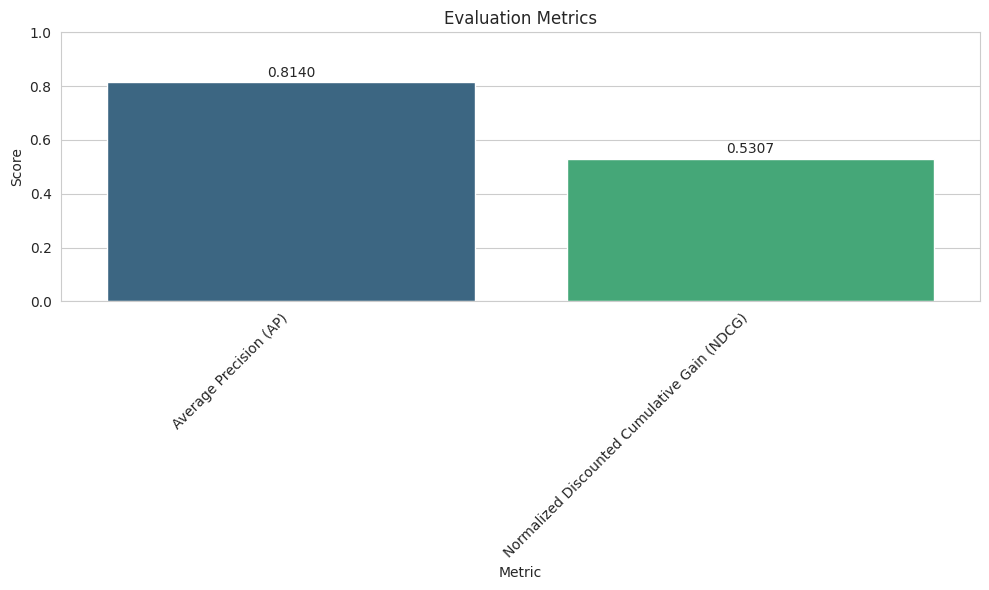

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, average_precision_score, ndcg_score

import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_similarity_search_advanced(df: pd.DataFrame, model: SentenceTransformer, index: faiss.IndexFlatL2, queries: list, true_labels: list, k: int = 3) -> dict:
    """
    Evaluate the similarity search model's performance on a set of queries.
    """
    all_relevant = []
    all_scores = []
    predictions = []

    for query, true_label in zip(queries, true_labels):
        results = search_similar_transactions(query, model, index, df, k)

        # Extract results
        top_k_results = results['top_k_results']
        predicted_label = results['prediction']

        # Collect the predicted label
        predictions.append(predicted_label)

        # Collect relevant items and their scores
        relevant_items = [1 if true_label in result['transaction_behavior'] else 0 for result in top_k_results]
        all_scores.extend([result['similarity_score'] for result in top_k_results])
        all_relevant.extend(relevant_items)

    # Precision at K
    precision_at_k = np.mean([sum([1 if item == 1 else 0 for item in relevant_items]) / k for relevant_items in [all_relevant]])

    # Recall at K
    recall_at_k = np.mean([sum(all_relevant) / len(true_labels)])

    # Mean Average Precision (MAP)
    average_precision = average_precision_score(all_relevant, all_scores)

    # NDCG
    if len(all_relevant) > 0:
        ndcg = ndcg_score([all_relevant], [all_scores], k=k)
    else:
        ndcg = 0.0

    return {
        'precision_at_k': precision_at_k,
        'recall_at_k': recall_at_k,
        'average_precision': average_precision,
        'ndcg': ndcg
    }



if __name__ == "__main__":
    model = load_model()

    # Prepare the sample
    sample_df = df_processed.sample(n=10, random_state=42)
    queries = sample_df['transaction_behavior'].str.slice(0, 120).tolist()
    true_labels = sample_df['bhv_isFraud'].tolist()

    # Initialize FAISS index and generate embeddings
    embeddings = np.vstack(df_processed['embeddings'].values)
    index = initialize_faiss_index(embeddings)

    # Evaluate the model
    metrics = evaluate_similarity_search_advanced(df_processed, model, index, queries, true_labels, k=3)

    # Print evaluation metrics
    print("Evaluation Metrics:")
    print(f"Average Precision: {metrics['average_precision']:.4f}")
    print(f"NDCG: {metrics['ndcg']:.4f}")

    # Metrics values
    metrics_dict = {
        'Average Precision (AP)': metrics['average_precision'],
        'Normalized Discounted Cumulative Gain (NDCG)': metrics['ndcg']
    }

    # Create a DataFrame for plotting
    metrics_df = pd.DataFrame(list(metrics_dict.items()), columns=['Metric', 'Score'])

    # Plotting the metrics
    plt.figure(figsize=(10, 6))

    # Bar plot
    sns.barplot(x='Metric', y='Score', data=metrics_df, palette='viridis')

    # Add titles and labels
    plt.title('Evaluation Metrics')
    plt.xlabel('Metric')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha='right')

    # Add value annotations
    for index, row in metrics_df.iterrows():
        plt.text(index, row['Score'] + 0.02, f'{row["Score"]:.4f}', ha='center')

    plt.tight_layout()
    plt.show()


## More Generative

In [180]:
import numpy as np
from sentence_transformers import SentenceTransformer
import faiss

def load_model(model_name: str = 'paraphrase-MiniLM-L6-v2') -> SentenceTransformer:
    """
    Load and return the SentenceTransformer model.
    """
    return SentenceTransformer(model_name)

def generate_embeddings(df: pd.DataFrame, column: str, model: SentenceTransformer) -> pd.DataFrame:
    """
    Generate embeddings for a specific column in the DataFrame.
    """
    df['embeddings'] = df[column].apply(lambda x: model.encode(x))
    return df

def initialize_faiss_index(embeddings: np.ndarray) -> faiss.IndexFlatL2:
    """
    Initialize and return a FAISS index.
    """
    dimension = embeddings.shape[1]
    index = faiss.IndexFlatL2(dimension)
    index.add(embeddings)
    return index

def search_and_generate_response(query: str, model: SentenceTransformer, index: faiss.IndexFlatL2,
                                 df: pd.DataFrame, api_key: str, k: int = 3, high_priority_terms: list = None) -> dict:
    """
    Search for similar transactions and generate a response based on the query and high-priority terms.
    """
    if high_priority_terms is None:
        high_priority_terms = []

    query_embedding = model.encode(query)
    D, I = index.search(np.array([query_embedding]), k)

    # Adjust the similarity scores based on high-priority terms
    results = []
    for idx, dist in zip(I[0], D[0]):
        transaction_behavior = df.iloc[idx]['transaction_behavior']
        similarity_score = 1 / (1 + dist)  # Convert distance to similarity score

        # Check for high-priority terms in the result
        priority_score = sum(term in transaction_behavior for term in high_priority_terms)
        adjusted_score = similarity_score + priority_score

        result = {
            'transaction_behavior': transaction_behavior,
            'similarity_score': adjusted_score
        }
        results.append(result)

    # Sort results based on the adjusted score
    results = sorted(results, key=lambda x: x['similarity_score'], reverse=True)

    # Generate a response based on the top results
    response = generate_response(results, query, api_key)

    # Extract the highest similarity transaction
    highest_similarity_transaction = results[0]['transaction_behavior']
    prediction = ' '.join(highest_similarity_transaction.split()[-2:])

    return {
        'top_k_results': results,
        'prediction': prediction,
        'response': response
    }

In [181]:
import openai

def generate_response(retrieved_docs: list, query: str, api_key: str) -> str:
    """
    Generate a response using a generative model based on the retrieved documents.
    """
    openai.api_key = api_key

    # Format the prompt for a chat-based model
    messages = [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": f"Query: {query}"},
        {"role": "user", "content": "Documents:"},
        {"role": "user", "content": "\n".join(doc['transaction_behavior'] for doc in retrieved_docs)}
    ]

    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=messages,
        max_tokens=150,
        temperature=0.7
    )

    return response.choices[0].message['content'].strip()

In [ ]:
if __name__ == "__main__":
    model = load_model()
    embeddings = np.vstack(df_processed['embeddings'].values)
    index = initialize_faiss_index(embeddings)

    # User Quyery
    query = "what is the type of A recurring transaction originated from a Teen male customer 180936571 from merchant 980657600 to category es_sportsandtoys with considerable amount is categorized as?"
    # Define words which needs high attention
    high_priority_terms = ["Teen", "considerable"]
    # For security purposes removed api key from the code. To generate the response assign an open_api_key to api_key variable

    api_key = #api-key-here

    # Perform search with a query and priority terms
    results = search_and_generate_response(query, model, index, df_processed, api_key, k=3, high_priority_terms=high_priority_terms)

    # Display the search results
    print("Top K Results:")
    for i, res in enumerate(results['top_k_results']):
        print(f"Result {i+1}:")
        print(f"Transaction Behavior: {res['transaction_behavior']}")
        print(f"Adjusted Similarity Score: {res['similarity_score']:.4f}")
        print("-" * 80)

    print("Prediction:")
    print(f"This transaction is a {results['prediction']}")

    print("Generated Response:")
    print(results['response'])


Top K Results:
Result 1:
Transaction Behavior: A recurring transaction originated from a Teen male customer 1358079072 from merchant 1741626453 to category es_sportsandtoys with considerable amount is categorized as fraud transaction
Adjusted Similarity Score: 2.1247
--------------------------------------------------------------------------------
Result 2:
Transaction Behavior: A recurring transaction originated from a Teen male customer 1955375790 from merchant 17379832 to category es_sportsandtoys with considerable amount is categorized as fraud transaction
Adjusted Similarity Score: 2.1242
--------------------------------------------------------------------------------
Result 3:
Transaction Behavior: A recurring transaction originated from a Teen male customer 1714895875 from merchant 1741626453 to category es_sportsandtoys with intermediate amount is categorized as genuine transaction
Adjusted Similarity Score: 1.1514
----------------------------------------------------------------